# 🔐 Machine Learning for Malicious URL / QR Detection

---

## Project Overview

In today's world, the modern internet is densely filled with Uniform Resource Locators (URLs) that point to countless resources across popular social communication platforms like WhatsApp, Instagram, and Messenger. Users can easily share links and QR codes for quick access to information. However, these platforms can be misused to spread **malicious content** through deceptive URLs or QR codes, leading to significant risks to user privacy and data security.

Attackers often perform **social media phishing** by utilizing deceptive URLs and QR codes to trick users into clicking or scanning, thereby injecting malware virus by redirecting them to harmful websites. This significantly leads to **malware infections, data breaches, and financial losses**.

This project aims to build a machine learning model that integrates detailed feature extraction (domain_age, tinyURL, web_traffic, DNS record) to improve overall static detection of malicious URLs.

---

## Problem Objectives

1. ✅ To identify URL patterns (lexical, domain-based) indicative of malicious sites
2. ✅ To evaluate and compare the performance of different ML models for malicious URLs classification
3. ✅ To develop a ML-based model capable of detecting phishing attempts based on URL patterns reliably

---

## Dataset: LegitPhish

| Metric | Value |
|--------|-------|
| **Total URLs** | 101,219 |
| **Phishing URLs** | 62.9% |
| **Legitimate URLs** | 37.1% |
| **Initial Features** | 18 |

**Data Source:** URLHaus database and other well-known repositories of malicious websites, as well as legitimate URLs collected from reputable sources like Wikipedia and Stack Overflow.

---

## Methodology

### Data Pre-processing
- Data Collection
- Data Cleaning
- Detailed Feature Extraction
- Data Splitting (80/20)

### Machine Learning (Binary Classification)
- Logistic Regression
- Random Forest
- XGBoost
- LightGBM

### Evaluation Metrics
- F1-Score
- Precision
- AUC-ROC
- Recall
- Confusion Matrix
- Accuracy

---

## References

1. Potpelwar, R. S., Kulkarni, U. V., & Waghmare, J. M. (2025). LegitPhish: A large-scale annotated dataset for URL-based phishing detection. Data in Brief, 63, 111972. https://doi.org/10.1016/j.dib.2025.111972
2. Xuan, C. D., Dinh, H., & Victor, T. (2020). Malicious URL Detection based on Machine Learning. International Journal of Advanced Computer Science and Applications, 11(1). https://doi.org/10.14569/ijacsa.2020.0110119
3. Aryan Nandu, Sosa, J., Pant, Y., Panchal, Y., & Sayyad, S. (2024). Malicious URL Detection Using Machine Learning. 1–6. https://doi.org/10.1109/asiancon62057.2024.10837752

---

## Authors

| Name | Student ID |
|------|------------|
| YIM WEN JUN | 24201054 |
| RICHIE TEOH | 24088171 |
| ELMER LEE JIA ZHAO | 24082366 |
| ANGELINE TAN JIE LIN | 24084444 |
| MICOLE CHUNG SYN TUNG | 24073625 |

---

# 1. Data Collection

This section loads the LegitPhish dataset containing URLs with pre-extracted features for phishing detection.

In [ ]:
!pip install mrmr_selection

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import time
import urllib
import urllib.request
from datetime import datetime
import requests
import math
import socket
from urllib.parse import urlparse
from mrmr import mrmr_classif
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [5]:
# Load the initial dataset
github_dataset = 'https://raw.githubusercontent.com/Elmer2408/WQD7006_Machine-learning-of-Malicious-URLs-Detection/main/url_features_extracted1.csv'
df = pd.read_csv(github_dataset)
df.columns = df.columns.str.lower()

print("="*60)
print("INITIAL DATASET LOADED")
print("="*60)
print(f"Total Samples: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
df.head()

INITIAL DATASET LOADED
Total Samples: 101,219
Total Features: 18


,url,url_length,has_ip_address,dot_count,https_flag,url_entropy,token_count,subdomain_count,query_param_count,tld_length,path_length,has_hyphen_in_domain,number_of_digits,tld_popularity,suspicious_file_extension,domain_name_length,percentage_numeric_chars,classlabel
0,https://keraekken-loagginnusa.godaddysites.com/,47,0,2,1,4.250669,6,1,1,3,1,1,0,1,0,12,0.0,0.0
1,https://metamsk01lgiix.godaddysites.com/,40,0,2,1,4.196439,6,1,1,3,1,0,2,1,0,12,5.0,0.0
2,http://myglobaltech.in/,23,0,1,0,3.936180,5,0,1,2,1,0,0,0,0,12,0.0,0.0
3,http://djtool-for-spotify.com/,30,0,1,0,3.894740,5,0,1,3,1,1,0,1,0,18,0.0,0.0
4,https://scearmcoommunnlty.com/invent/freind/get,47,0,1,1,4.143127,7,0,1,3,18,0,0,1,0,17,0.0,0.0


In [6]:
# Feature descriptions
descriptions = {
    "url": "The full URL string (original data).",
    "url_length": "Total number of characters in the URL.",
    "has_ip_address": "Binary flag (1/0): whether the URL contains an IP address.",
    "dot_count": "Number of . characters in the URL.",
    "https_flag": "Binary flag (1/0): whether the URL uses HTTPS.",
    "url_entropy": "Shannon entropy of the URL string – higher values indicate more randomness.",
    "token_count": "Number of tokens/words in the URL.",
    "subdomain_count": "Number of subdomains in the URL.",
    "query_param_count": "Number of query parameters (after ?).",
    "tld_length": "Length of the Top-Level Domain (e.g., 'com' = 3).",
    "path_length": "Length of the path part after the domain.",
    "has_hyphen_in_domain": "Binary flag (1/0): whether the domain contains a hyphen (-).",
    "number_of_digits": "Total number of numeric characters in the URL.",
    "tld_popularity": "Binary flag (1/0): whether the TLD is popular.",
    "suspicious_file_extension": "Binary flag (1/0): indicates if the URL ends with suspicious extensions (e.g., .exe, .zip).",
    "domain_name_length": "Length of the domain name.",
    "percentage_numeric_chars": "Percentage of numeric characters in the URL.",
    "classlabel": "Target label: 1 = Legitimate, 0 = Phishing.",
}

# Create metadata table
metadata = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": df.dtypes.values,
    "Non-Null Count": df.notnull().sum().values,
    "Null Count": df.isnull().sum().values,
    "Unique Values": df.nunique().values,
    "Sample Values": [df[col].dropna().unique()[:3] for col in df.columns],
    "Description": [descriptions[col] for col in df.columns]
})

pd.set_option('display.max_colwidth', None)
print("="*60)
print("DATASET METADATA")
print("="*60)
metadata

DATASET METADATA


,Column Name,Data Type,Non-Null Count,Null Count,Unique Values,Sample Values,Description
0,url,object,101219,0,100873,"[https://keraekken-loagginnusa.godaddysites.com/, https://metamsk01lgiix.godaddysites.com/, http://myglobaltech.in/]",The full URL string (original data).
1,url_length,int64,101219,0,236,"[47, 40, 23]",Total number of characters in the URL.
2,has_ip_address,int64,101219,0,2,"[0, 1]",Binary flag (1/0): whether the URL contains an IP address.
3,dot_count,int64,101219,0,19,"[2, 1, 3]",Number of . characters in the URL.
4,https_flag,int64,101219,0,2,"[1, 0]",Binary flag (1/0): whether the URL uses HTTPS.
5,url_entropy,float64,101219,0,12394,"[4.250669436, 4.196439345, 3.936180434]",Shannon entropy of the URL string – higher values indicate more randomness.
6,token_count,int64,101219,0,32,"[6, 5, 7]",Number of tokens/words in the URL.
7,subdomain_count,int64,101219,0,7,"[1, 0, 2]",Number of subdomains in the URL.
8,query_param_count,int64,101219,0,9,"[1, 4, 2]",Number of query parameters (after ?).
9,tld_length,int64,101219,0,11,"[3, 2, 4]","Length of the Top-Level Domain (e.g., 'com' = 3)."


---

# 2. Data Cleaning

This section handles missing values, duplicates, and data type conversions to prepare the dataset for analysis.

In [7]:
# Data Quality Check
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate URL entries: {duplicates}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing Values per Column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")
print(f"\nTotal Missing in Target (classlabel): {df['classlabel'].isnull().sum()}")

DATA QUALITY CHECK
Duplicate URL entries: 346

Missing Values per Column:
classlabel    1
dtype: int64

Total Missing in Target (classlabel): 1


In [8]:
# Clean the dataset
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(how='any')  # Remove rows with null values
df_cleaned['classlabel'] = df_cleaned['classlabel'].astype(int)  # Convert float64 to int64
df_cleaned.columns = df_cleaned.columns.str.lower()

print("="*60)
print("AFTER DATA CLEANING")
print("="*60)
print(f"Original Dataset Size: {df.shape[0]:,}")
print(f"Cleaned Dataset Size: {df_cleaned.shape[0]:,}")
print(f"Rows Removed: {df.shape[0] - df_cleaned.shape[0]:,}")

# Updated metadata after cleaning
metadata_cleaned = pd.DataFrame({
    "Column Name": df_cleaned.columns,
    "Data Type": df_cleaned.dtypes.values,
    "Non-Null Count": df_cleaned.notnull().sum().values,
    "Null Count": df_cleaned.isnull().sum().values,
    "Unique Values": df_cleaned.nunique().values,
    "Sample Values": [df_cleaned[col].dropna().unique()[:3] for col in df_cleaned.columns],
    "Description": [descriptions[col] for col in df_cleaned.columns]
})

metadata_cleaned

AFTER DATA CLEANING
Original Dataset Size: 101,219
Cleaned Dataset Size: 101,218
Rows Removed: 1


,Column Name,Data Type,Non-Null Count,Null Count,Unique Values,Sample Values,Description
0,url,object,101218,0,100872,"[https://keraekken-loagginnusa.godaddysites.com/, https://metamsk01lgiix.godaddysites.com/, http://myglobaltech.in/]",The full URL string (original data).
1,url_length,int64,101218,0,236,"[47, 40, 23]",Total number of characters in the URL.
2,has_ip_address,int64,101218,0,2,"[0, 1]",Binary flag (1/0): whether the URL contains an IP address.
3,dot_count,int64,101218,0,19,"[2, 1, 3]",Number of . characters in the URL.
4,https_flag,int64,101218,0,2,"[1, 0]",Binary flag (1/0): whether the URL uses HTTPS.
5,url_entropy,float64,101218,0,12394,"[4.250669436, 4.196439345, 3.936180434]",Shannon entropy of the URL string – higher values indicate more randomness.
6,token_count,int64,101218,0,32,"[6, 5, 7]",Number of tokens/words in the URL.
7,subdomain_count,int64,101218,0,7,"[1, 0, 2]",Number of subdomains in the URL.
8,query_param_count,int64,101218,0,9,"[1, 4, 2]",Number of query parameters (after ?).
9,tld_length,int64,101218,0,11,"[3, 2, 4]","Length of the Top-Level Domain (e.g., 'com' = 3)."


---

# 3. Detailed Feature Extraction

This section defines additional feature extraction functions for HTML, JavaScript, and domain-based features. These functions can be used for real-time URL analysis.

**Note:** For this experiment, we use a pre-extracted dataset to avoid API rate limits and long processing times.

In [9]:
# Feature Extraction Functions

def DNSRecord(url):
    """
    Check if the domain has a valid DNS record.
    Returns: 1 = Legitimate (DNS exists), 0 = Phishing (No DNS)
    """
    try:
        hostname = urlparse(url).netloc
        if ':' in hostname:
            hostname = hostname.split(':')[0]
        if not hostname:
            return 0
        try:
            socket.gethostbyname(hostname)
            return 1
        except socket.gaierror:
            return 0
        except Exception:
            return 0
    except Exception:
        return 0


def iframe(response):
    """
    Check if the webpage contains iframe tags (potential phishing indicator).
    Returns: 1 = Contains iframe, 0 = No iframe
    """
    if response == "":
        return 0
    else:
        if re.findall(r"<iframe", response):
            return 1
        else:
            return 0


def mouseOver(response):
    """
    Check if the webpage uses onmouseover events (potential phishing technique).
    Returns: 0 = Contains onmouseover (suspicious), 1 = No onmouseover
    """
    if response == "":
        return 0
    else:
        if re.findall(r"onmouseover", response):
            return 0
        else:
            return 1


def rightClick(response):
    """
    Check if the webpage disables right-click (potential phishing technique).
    Returns: 1 = Right-click disabled, 0 = Normal
    """
    if response == "":
        return 0
    else:
        if re.findall(r"event.button ?== ?2", response):
            return 1
        else:
            return 0


def forwarding(url):
    """
    Check the number of redirects for a URL.
    Returns: 1 = Legitimate (≤2 redirects), 0 = Suspicious (>2 redirects)
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=5)
        redirect_count = len(response.history)
        if redirect_count <= 2:
            return 1
        else:
            return 0
    except Exception:
        return 0


print("✅ Feature extraction functions defined successfully!")
print("\nAvailable functions:")
print("  - DNSRecord(url): Check DNS record existence")
print("  - iframe(response): Detect iframe tags")
print("  - mouseOver(response): Detect onmouseover events")
print("  - rightClick(response): Detect right-click blocking")
print("  - forwarding(url): Count URL redirects")

✅ Feature extraction functions defined successfully!

Available functions:
  - DNSRecord(url): Check DNS record existence
  - iframe(response): Detect iframe tags
  - mouseOver(response): Detect onmouseover events
  - rightClick(response): Detect right-click blocking
  - forwarding(url): Count URL redirects


In [10]:
# Load the complete dataset with pre-extracted features
github_dataset = 'https://raw.githubusercontent.com/Elmer2408/WQD7006_Machine-learning-of-Malicious-URLs-Detection/main/urldata_with_features_complete.csv'
df_extract = pd.read_csv(github_dataset)
df_extract.columns = df_extract.columns.str.lower()

print("="*60)
print("COMPLETE DATASET WITH EXTRACTED FEATURES")
print("="*60)
print(f"Total URLs: {df_extract.shape[0]:,}")
print(f"Total Features: {df_extract.shape[1]}")
print(f"\nFeatures: {df_extract.columns.tolist()}")
df_extract.head()

COMPLETE DATASET WITH EXTRACTED FEATURES
Total URLs: 101,218
Total Features: 25

Features: ['url', 'url_length', 'has_ip_address', 'dot_count', 'https_flag', 'url_entropy', 'token_count', 'subdomain_count', 'query_param_count', 'tld_length', 'path_length', 'has_hyphen_in_domain', 'number_of_digits', 'tld_popularity', 'suspicious_file_extension', 'domain_name_length', 'percentage_numeric_chars', 'classlabel', 'dns_record', 'web_traffic', 'domain_age', 'iframe_redirection', 'mouse_over', 'right_click', 'web_forwarding']


,url,url_length,has_ip_address,dot_count,https_flag,url_entropy,token_count,subdomain_count,query_param_count,tld_length,...,domain_name_length,percentage_numeric_chars,classlabel,dns_record,web_traffic,domain_age,iframe_redirection,mouse_over,right_click,web_forwarding
0,https://keraekken-loagginnusa.godaddysites.com/,47,0,2,1,4.250669,6,1,1,3,...,12,0.0,0,1,0,0,0,1,0,1
1,https://metamsk01lgiix.godaddysites.com/,40,0,2,1,4.196439,6,1,1,3,...,12,5.0,0,1,0,0,0,1,0,1
2,http://myglobaltech.in/,23,0,1,0,3.936180,5,0,1,2,...,12,0.0,0,0,0,0,0,1,0,0
3,http://djtool-for-spotify.com/,30,0,1,0,3.894740,5,0,1,3,...,18,0.0,0,1,0,0,0,1,0,1
4,https://scearmcoommunnlty.com/invent/freind/get,47,0,1,1,4.143127,7,0,1,3,...,17,0.0,0,0,0,0,0,1,0,0


## Removal of Dirty Rows
subdomain_count == -1, data checking shows subdomain_count all arised from URLs that do not contain "http://" which might be due to inconsistent data For example:'docs.google.com/spreadsheet/viewform?formkey=dE5rVEdSV2pBdkpSRy11V3o2eDdwbnc6MQ' is clearly a Google Spreadsheet link with the http:// part truncated, hence our group come to the conclusion of removing the 1,308 rows with subdomain_count == -1 as we believe it does not provide signal, but only noise to the modelling

In [11]:
#The result of Subdomain_count of -1 URL
df_extract[df_extract['subdomain_count'] == -1]['url'].head()

,url
599,Offline
699,nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526
700,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php
701,serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/
702,mail.printakid.com/www.online.americanexpress.com/index.html


In [12]:
df_extract = df_extract[(df_extract['url'] != 'Offline') & (df_extract['subdomain_count'] != -1)]
df_extract.describe()

,url_length,has_ip_address,dot_count,https_flag,url_entropy,token_count,subdomain_count,query_param_count,tld_length,path_length,...,domain_name_length,percentage_numeric_chars,classlabel,dns_record,web_traffic,domain_age,iframe_redirection,mouse_over,right_click,web_forwarding
count,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,99910.000000,...,99910.000000,99910.000000,99910.000000,99910.000000,99910.0,99910.000000,99910.0,99910.0,99910.0,99910.000000
mean,34.440056,0.491142,2.994475,0.410950,3.971087,6.848874,1.544400,1.006546,5.068392,7.809989,...,6.374117,24.296763,0.375738,0.895556,0.0,0.277980,0.0,1.0,0.0,0.365619
std,14.284147,0.499924,0.876555,0.492009,0.301597,1.528764,0.558363,0.130969,2.879740,12.289652,...,5.328788,22.531372,0.484315,0.305837,0.0,0.448006,0.0,0.0,0.0,0.481606
min,15.000000,0.000000,1.000000,0.000000,2.610549,4.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000
25%,27.000000,0.000000,2.000000,0.000000,3.770942,5.000000,1.000000,1.000000,3.000000,0.000000,...,3.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,1.0,0.0,0.000000
50%,31.000000,0.000000,3.000000,0.000000,3.935399,7.000000,2.000000,1.000000,3.000000,2.000000,...,3.000000,20.689655,0.000000,1.000000,0.0,0.000000,0.0,1.0,0.0,0.000000
75%,35.000000,1.000000,4.000000,1.000000,4.091135,8.000000,2.000000,1.000000,8.000000,7.000000,...,10.000000,47.058824,1.000000,1.000000,0.0,1.000000,0.0,1.0,0.0,1.000000
max,277.000000,1.000000,9.000000,1.000000,5.487944,20.000000,5.000000,4.000000,10.000000,258.000000,...,36.000000,65.957447,1.000000,1.000000,0.0,1.000000,0.0,1.0,0.0,1.000000


---

# 4. Exploratory Data Analysis (EDA)

This section explores the dataset structure, class distribution, feature correlations, and distributions to understand the data characteristics.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total URLs: {df_extract.shape[0]:,}")
print(f"Total Features: {df_extract.shape[1]}")
print(f"\nColumn Names:\n{df_extract.columns.tolist()}")

DATASET OVERVIEW
Total URLs: 99,910
Total Features: 25

Column Names:
['url', 'url_length', 'has_ip_address', 'dot_count', 'https_flag', 'url_entropy', 'token_count', 'subdomain_count', 'query_param_count', 'tld_length', 'path_length', 'has_hyphen_in_domain', 'number_of_digits', 'tld_popularity', 'suspicious_file_extension', 'domain_name_length', 'percentage_numeric_chars', 'classlabel', 'dns_record', 'web_traffic', 'domain_age', 'iframe_redirection', 'mouse_over', 'right_click', 'web_forwarding']


CLASS DISTRIBUTION

Phishing URLs (0): 62,370 (62.4%)
Legitimate URLs (1): 37,540 (37.6%)


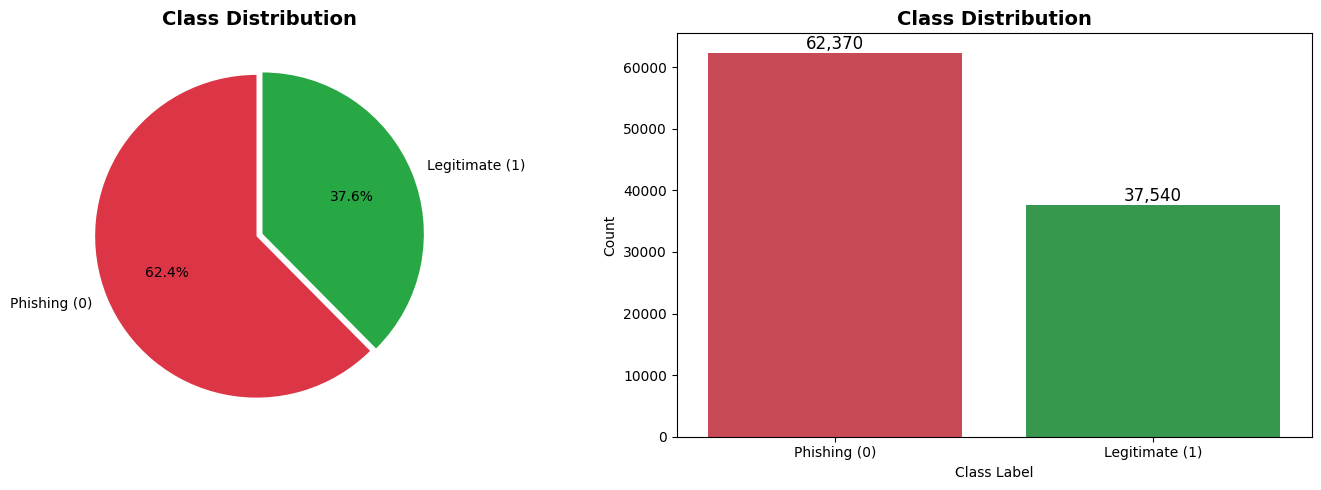

In [14]:
# Class Distribution
print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

class_counts = df_extract['classlabel'].value_counts()
class_percent = df_extract['classlabel'].value_counts(normalize=True) * 100

print(f"\nPhishing URLs (0): {class_counts[0]:,} ({class_percent[0]:.1f}%)")
print(f"Legitimate URLs (1): {class_counts[1]:,} ({class_percent[1]:.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie Chart
colors = ['#dc3545', '#28a745']
axes[0].pie(class_counts, labels=['Phishing (0)', 'Legitimate (1)'], autopct='%1.1f%%',
            colors=colors, explode=(0.02, 0.02), startangle=90)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# Bar Chart
ax = sns.countplot(x='classlabel', data=df_extract, palette=['#dc3545', '#28a745'], ax=axes[1])
axes[1].set_xticklabels(['Phishing (0)', 'Legitimate (1)'])
axes[1].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [15]:
# Statistical Summary
print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)
df_extract.describe().T

STATISTICAL SUMMARY


,count,mean,std,min,25%,50%,75%,max
url_length,99910.0,34.440056,14.284147,15.000000,27.000000,31.000000,35.000000,277.000000
has_ip_address,99910.0,0.491142,0.499924,0.000000,0.000000,0.000000,1.000000,1.000000
dot_count,99910.0,2.994475,0.876555,1.000000,2.000000,3.000000,4.000000,9.000000
https_flag,99910.0,0.410950,0.492009,0.000000,0.000000,0.000000,1.000000,1.000000
url_entropy,99910.0,3.971087,0.301597,2.610549,3.770942,3.935399,4.091135,5.487944
token_count,99910.0,6.848874,1.528764,4.000000,5.000000,7.000000,8.000000,20.000000
subdomain_count,99910.0,1.544400,0.558363,0.000000,1.000000,2.000000,2.000000,5.000000
query_param_count,99910.0,1.006546,0.130969,1.000000,1.000000,1.000000,1.000000,4.000000
tld_length,99910.0,5.068392,2.879740,1.000000,3.000000,3.000000,8.000000,10.000000
path_length,99910.0,7.809989,12.289652,0.000000,0.000000,2.000000,7.000000,258.000000


FEATURE DISTRIBUTION BY CLASS


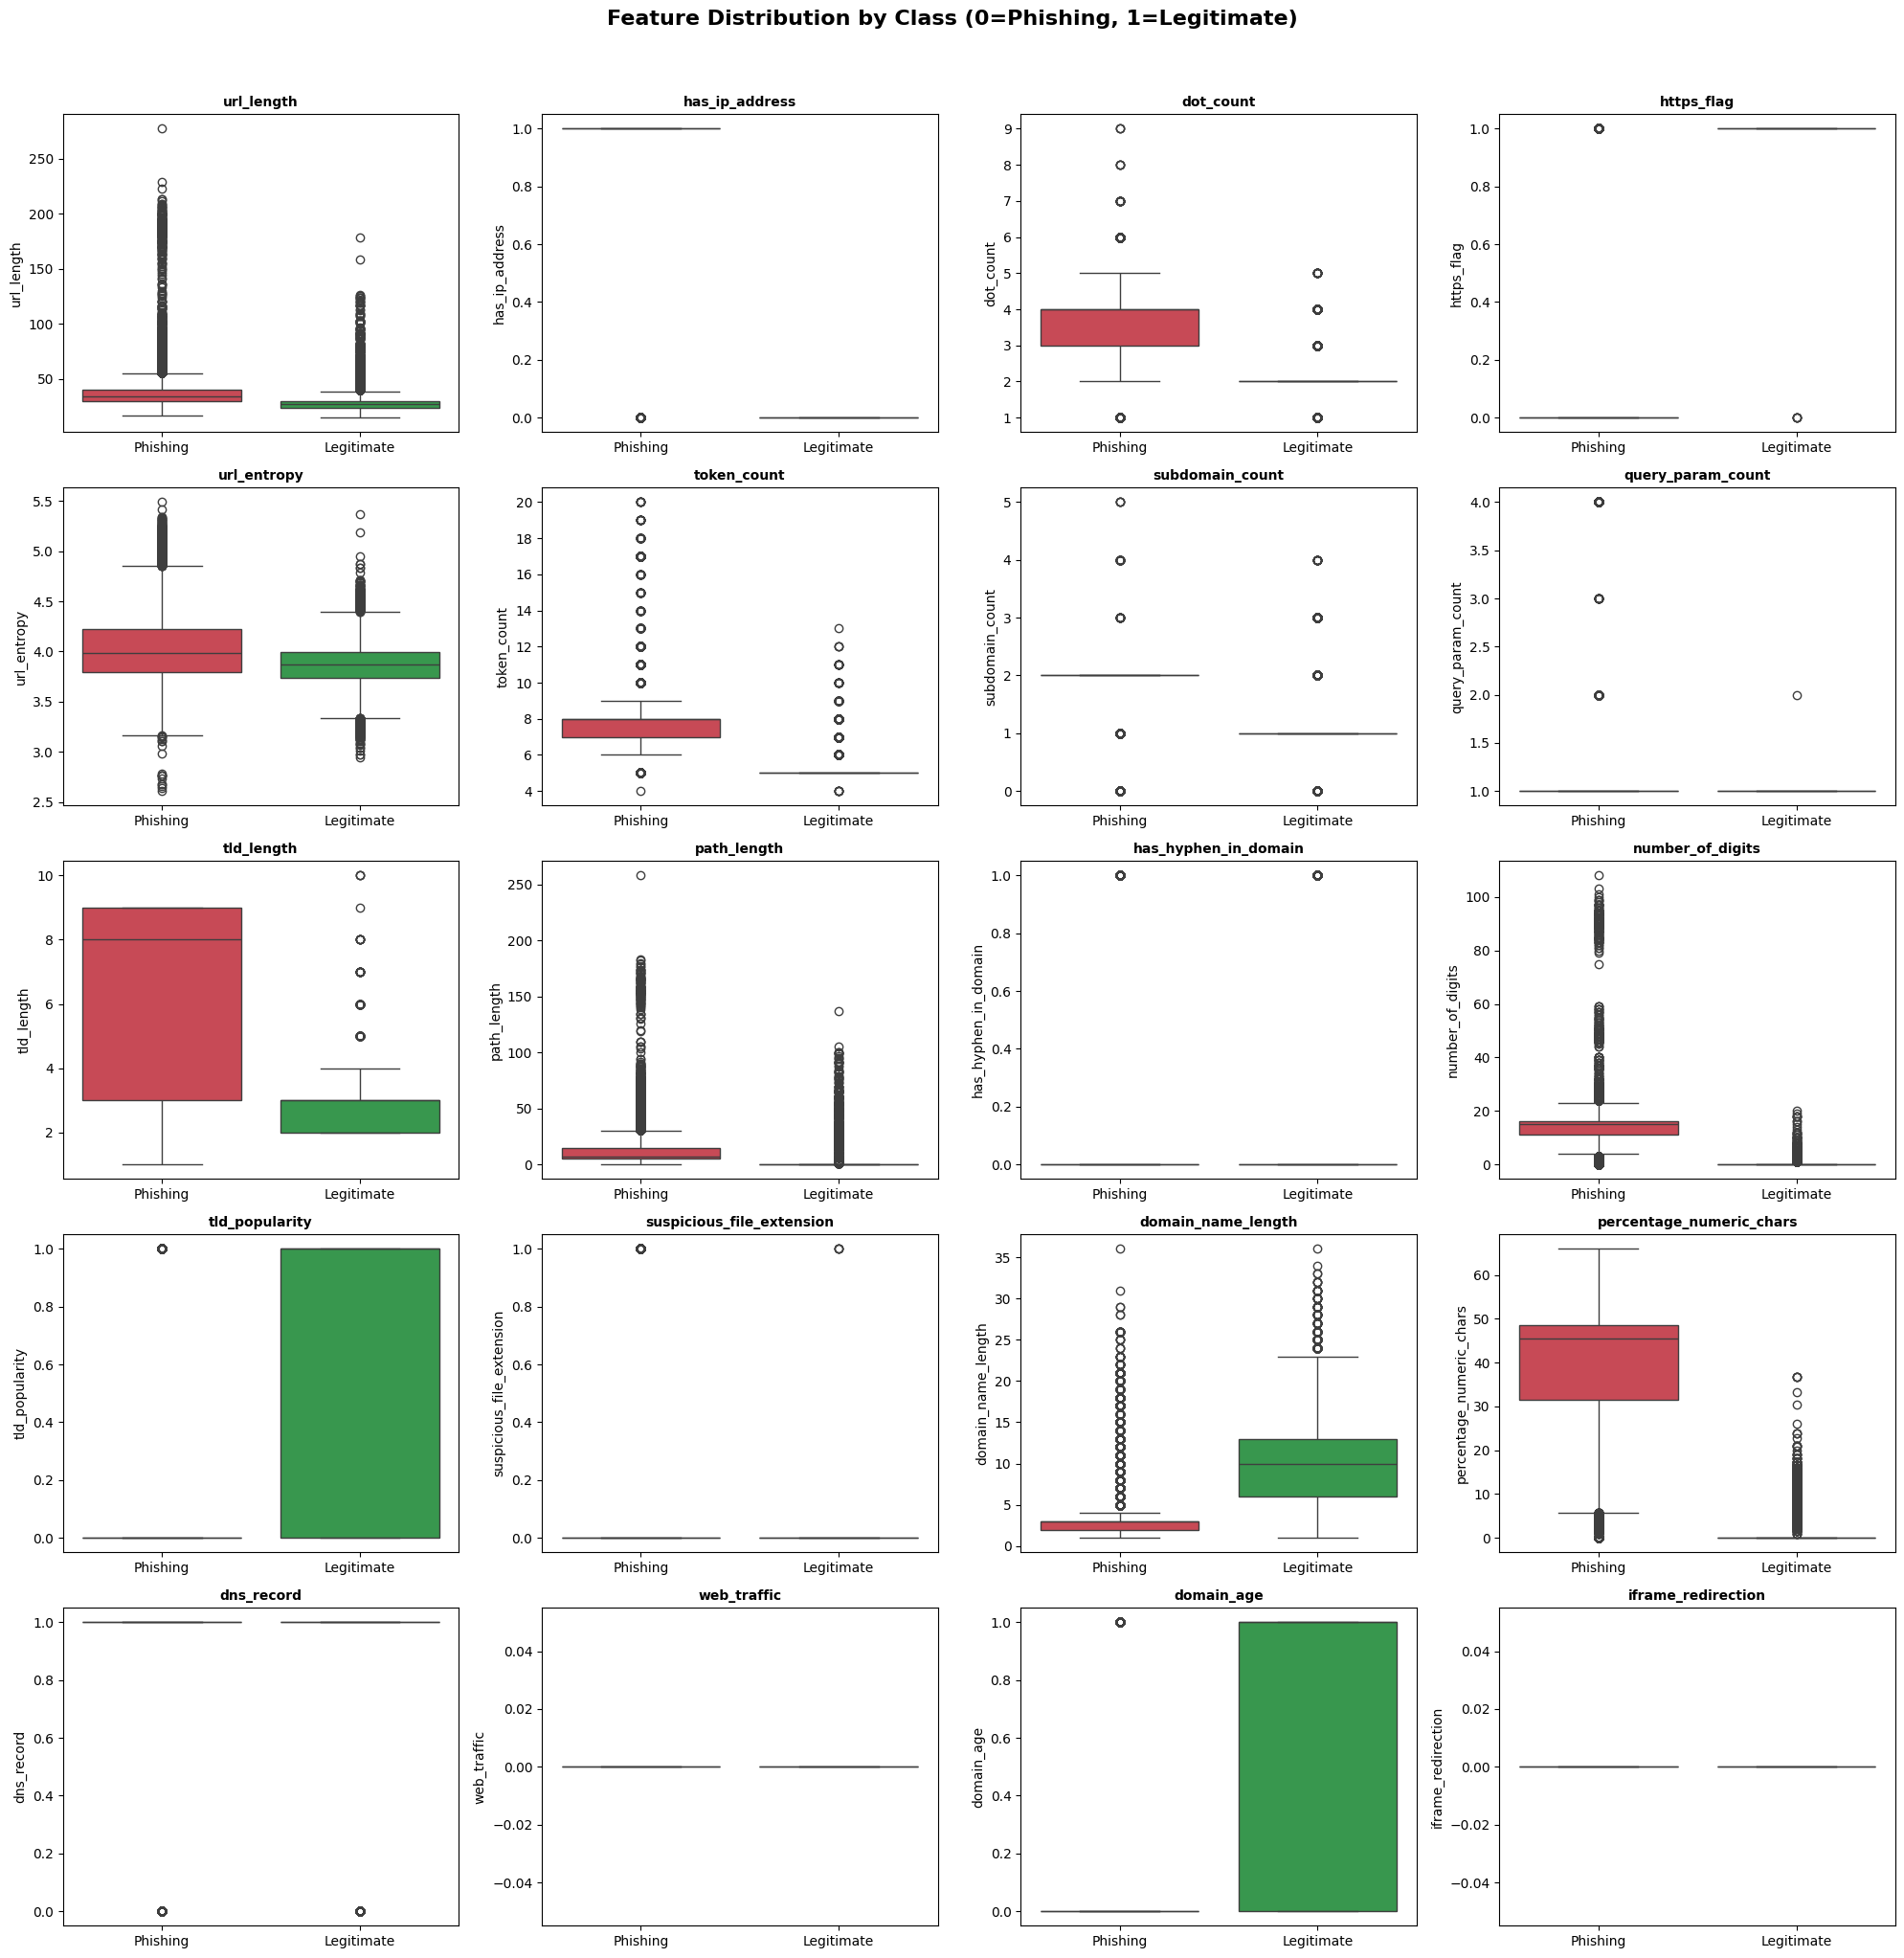

In [16]:
# Feature Distribution by Class (All Features)
print("="*60)
print("FEATURE DISTRIBUTION BY CLASS")
print("="*60)

numeric_df = df_extract.select_dtypes(include=[np.number])
feature_cols = [col for col in numeric_df.columns if col not in ['classlabel']]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for idx, col in enumerate(feature_cols[:20]):
    sns.boxplot(x='classlabel', y=col, data=df_extract, ax=axes[idx], palette=['#dc3545', '#28a745'])
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_xticklabels(['Phishing', 'Legitimate'])

for idx in range(len(feature_cols[:20]), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distribution by Class (0=Phishing, 1=Legitimate)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# Initialize an empty list to store boolean values indicating if each column is categorical
is_categorical = []

# Initialize empty lists to store the names of categorical and non-categorical columns
categorical_columns = []
non_categorical_columns = []

exclude_cols = ['url', 'classlabel']

for col in df_extract.columns:
  if col not in exclude_cols:
    # Checking if the column has only two unique values, implying it's categorical
    if df_extract[col].nunique() == 2:
        # Getting the unique values of the current column
        unique_values = df_extract[col].unique()
        # Printing the column name and its unique values
        is_categorical.append(True) # Appending True to indicate the column is categorical
        categorical_columns.append(col)
    else:
        # If the column has more than two unique values, it's non-categorical
        is_categorical.append(False) # Appending False to indicate the column is not categorical
        non_categorical_columns.append(col)

# print(is_categorical)

# Display the list of categorical columns
print("Categorical columns: ", categorical_columns)

# Display the list of non-categorical columns
print("Non-categorical columns: ", non_categorical_columns)

Categorical columns:  ['has_ip_address', 'https_flag', 'has_hyphen_in_domain', 'tld_popularity', 'suspicious_file_extension', 'dns_record', 'domain_age', 'web_forwarding']
Non-categorical columns:  ['url_length', 'dot_count', 'url_entropy', 'token_count', 'subdomain_count', 'query_param_count', 'tld_length', 'path_length', 'number_of_digits', 'domain_name_length', 'percentage_numeric_chars', 'web_traffic', 'iframe_redirection', 'mouse_over', 'right_click']


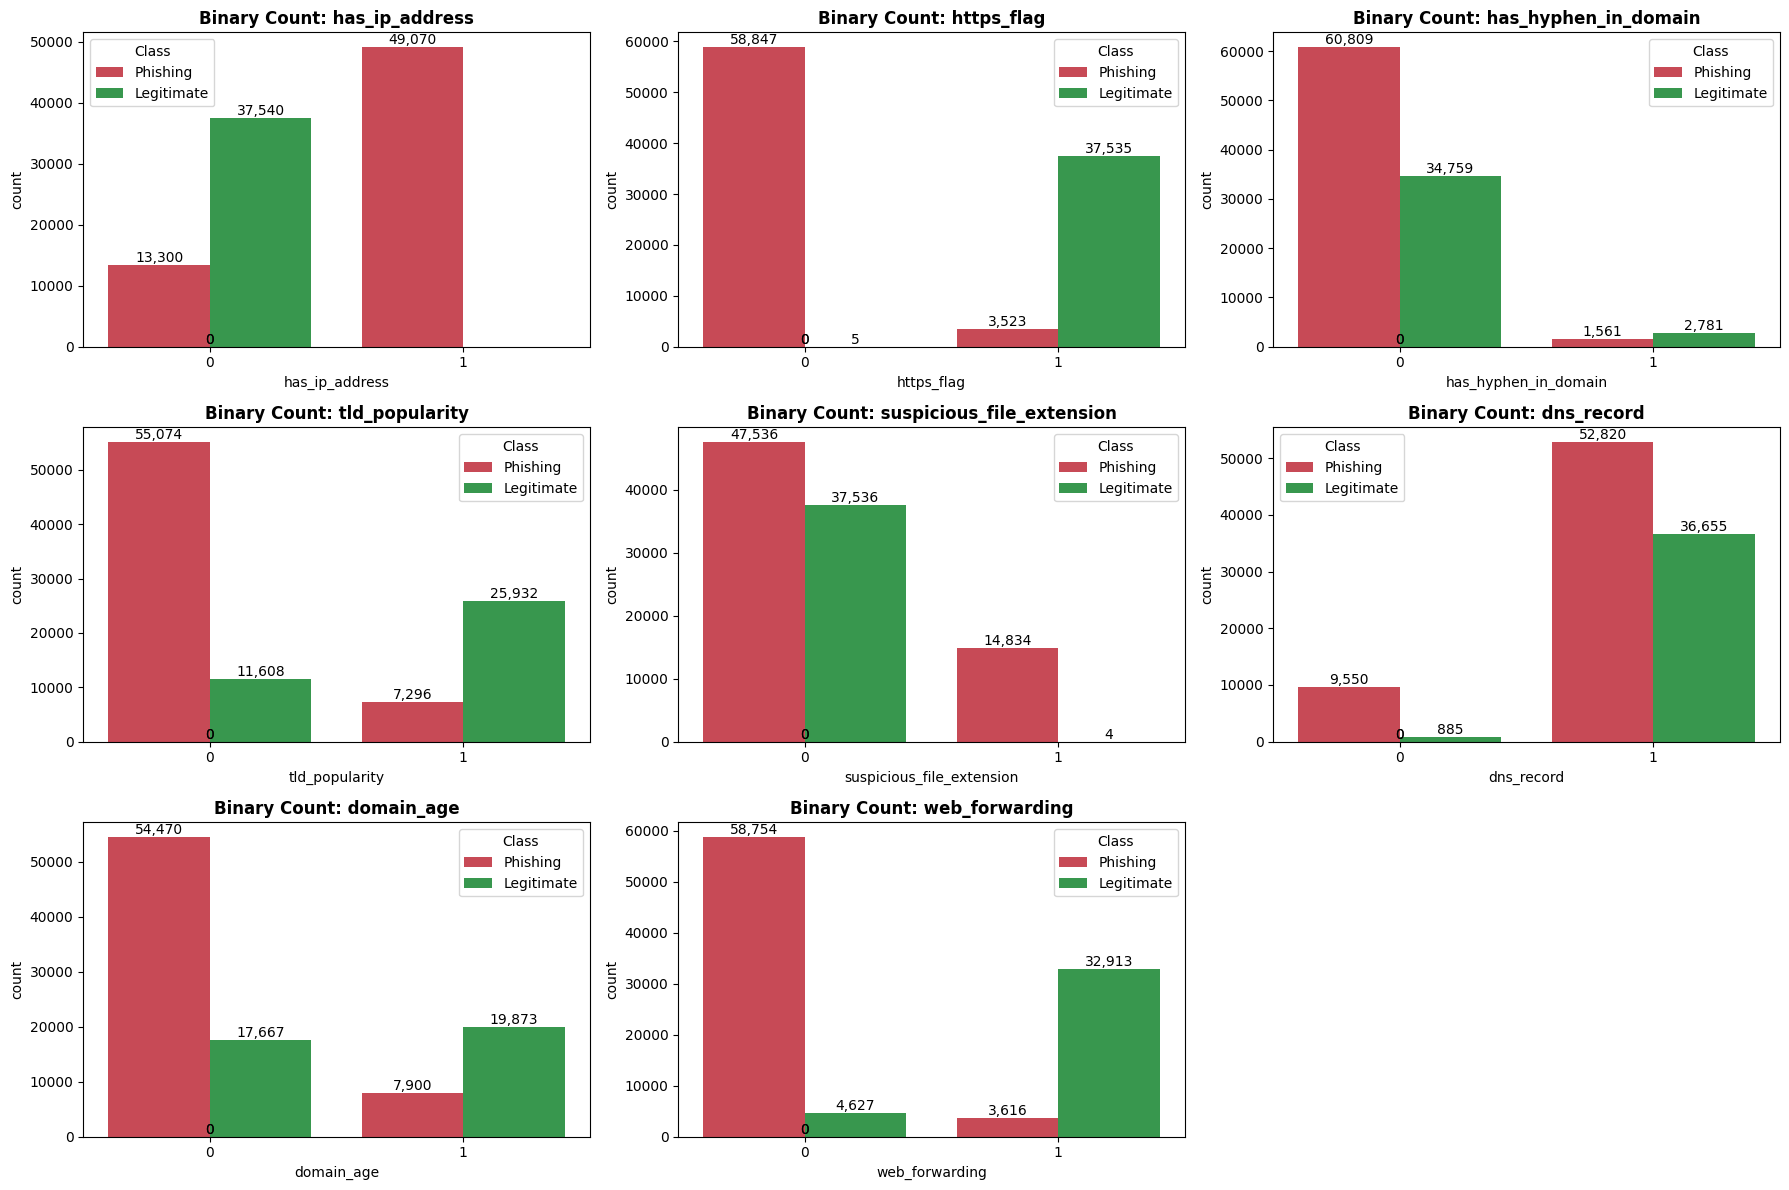

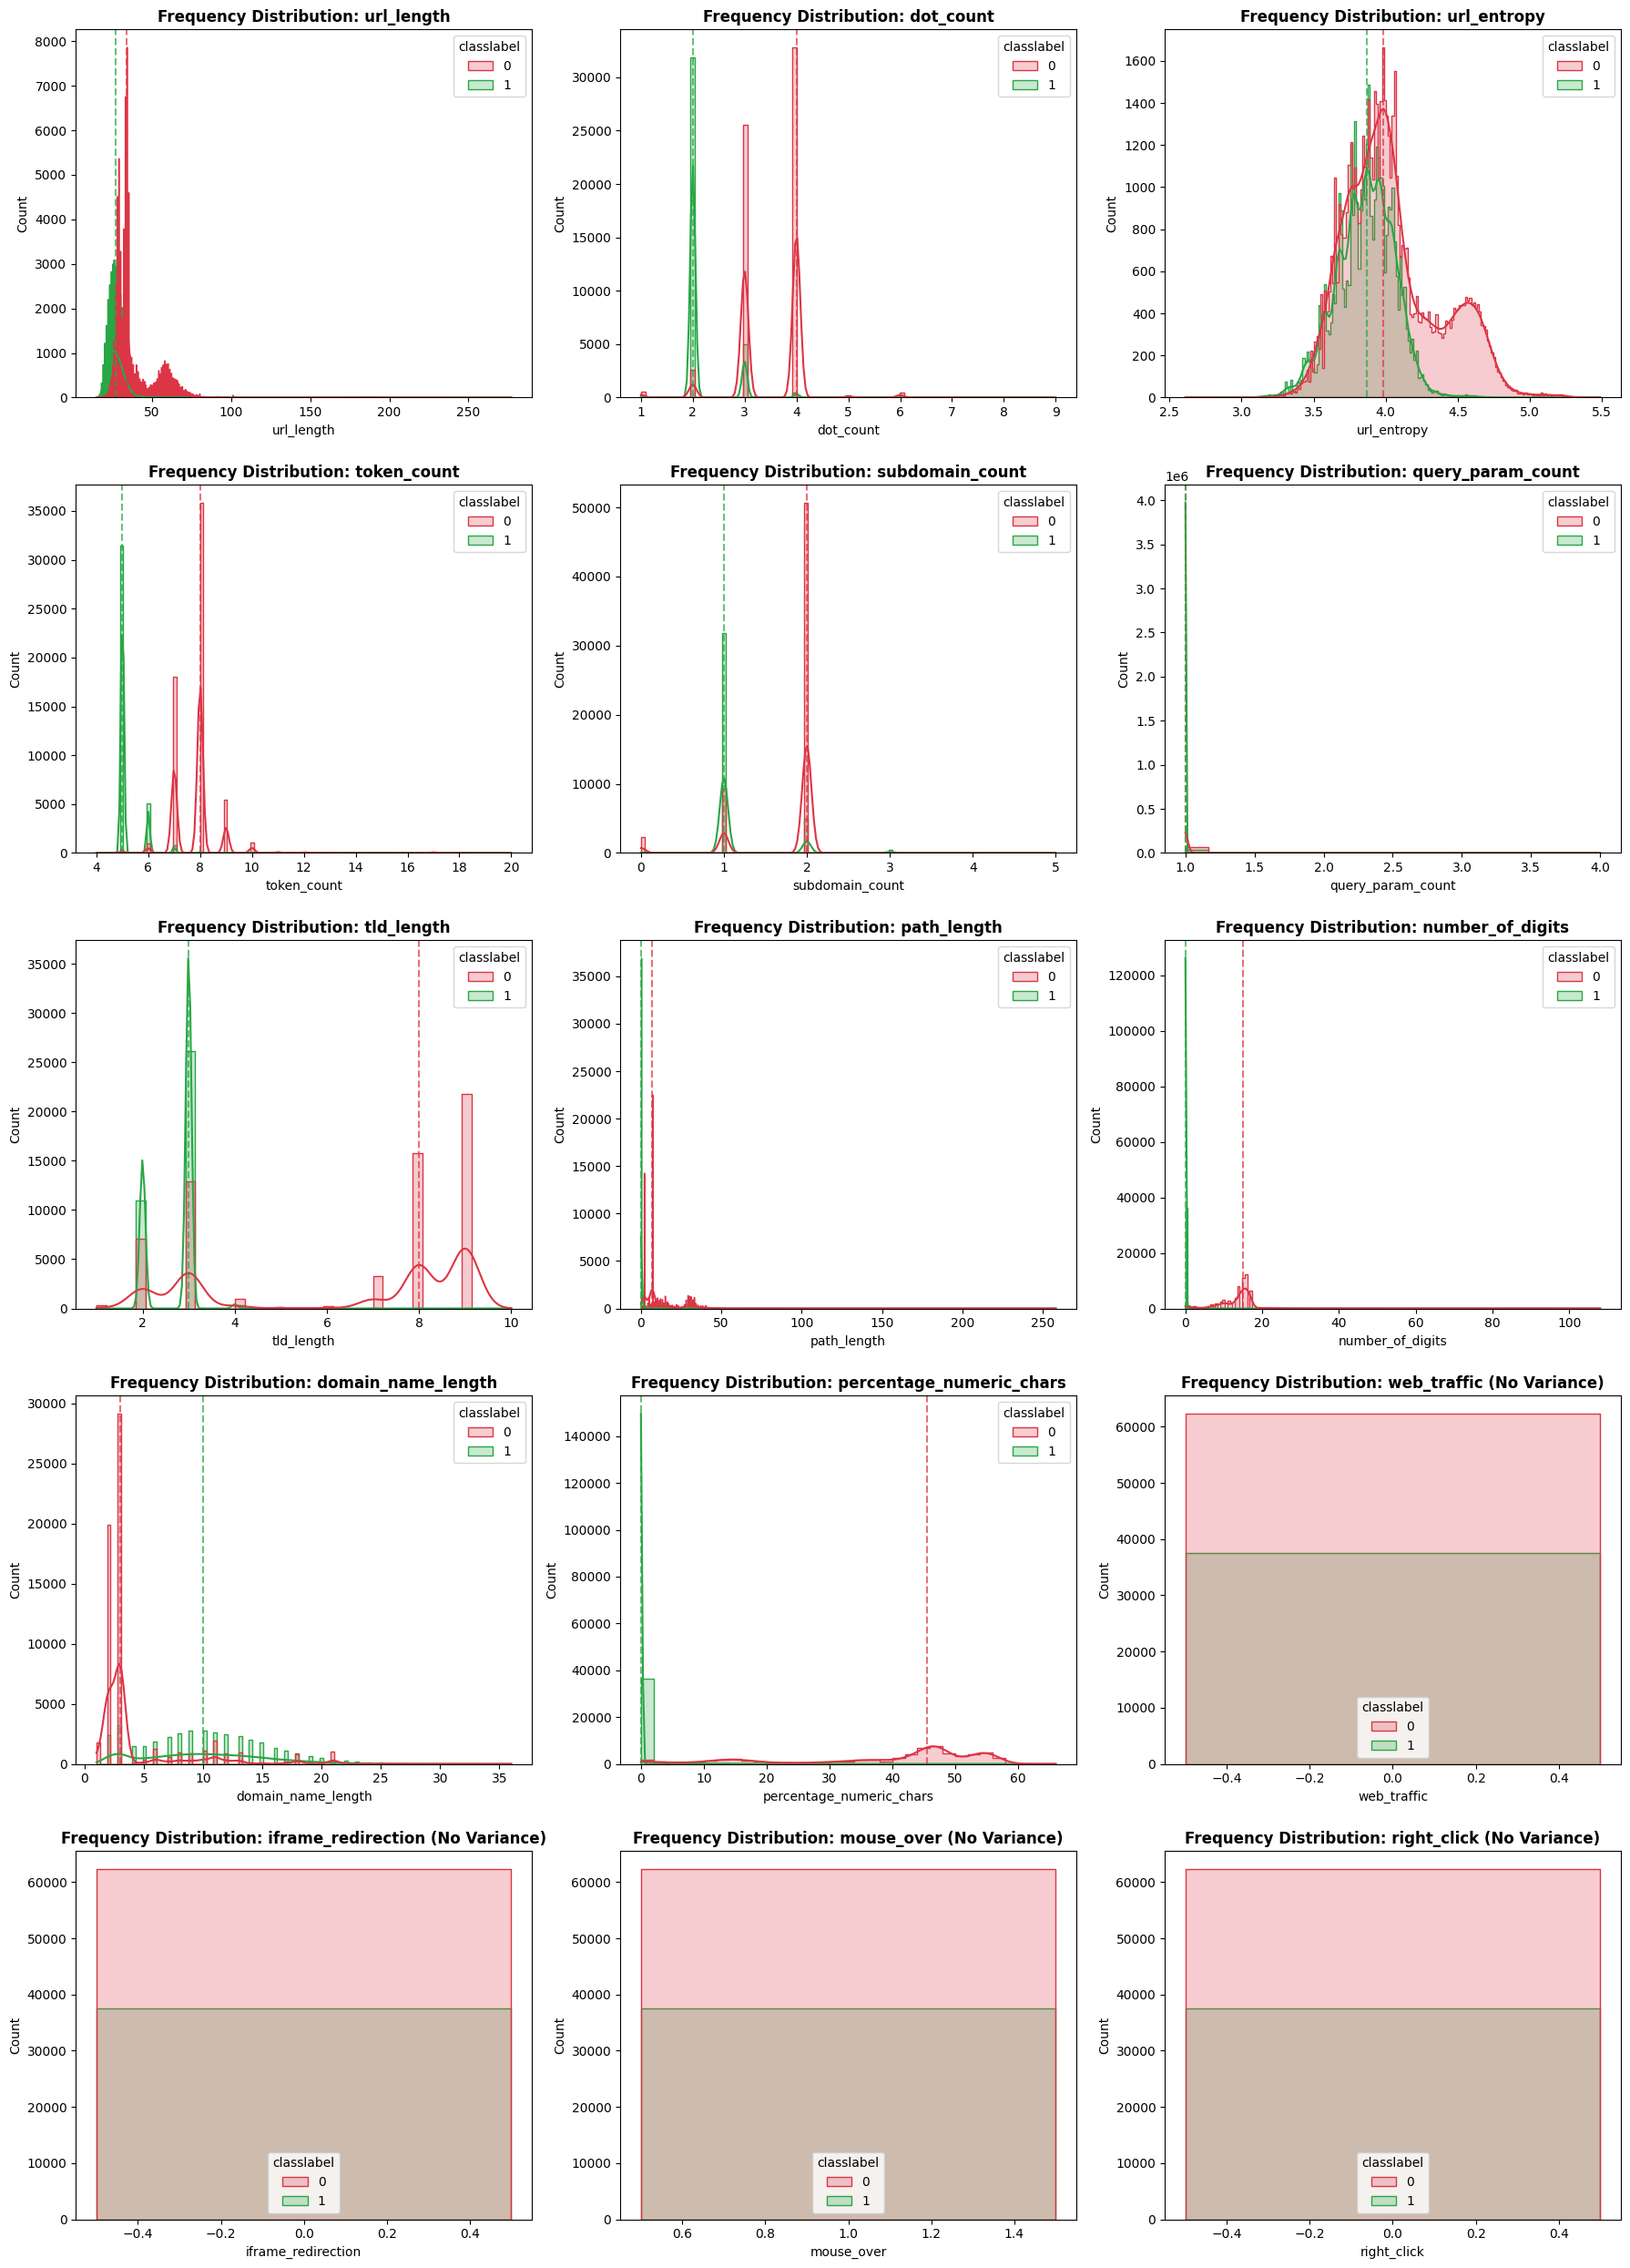

In [19]:
binary_features = categorical_columns

numeric_features = non_categorical_columns

#Binary Feature
n_bin = len(binary_features)
rows_bin = math.ceil(n_bin / 3)
fig1, axes1 = plt.subplots(rows_bin, 3, figsize=(18, 4 * rows_bin))
axes1 = axes1.flatten()

for i, col in enumerate(binary_features):
    ax = sns.countplot(x=col, hue='classlabel', data=df_extract, ax=axes1[i], palette=['#dc3545', '#28a745'])
    axes1[i].set_title(f'Binary Count: {col}', fontsize=12, fontweight='bold')
    axes1[i].legend(title='Class', labels=['Phishing', 'Legitimate'])
    # Add number labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

for j in range(i + 1, len(axes1)): axes1[j].set_visible(False)
plt.tight_layout()
plt.show()

#Non-categorical feature
n_num = len(numeric_features)
rows_num = math.ceil(n_num / 3)
fig2, axes2 = plt.subplots(rows_num, 3, figsize=(18, 5 * rows_num))
axes2 = axes2.flatten()

for i, col in enumerate(numeric_features):
  if col != 'url':
    # Check if the column has variance before attempting KDE
    if df_extract[col].std() > 0:
        # We use multiple="dodge" or element="step" to see both distributions clearly
        sns.histplot(data=df_extract, x=col, hue='classlabel', kde=True, ax=axes2[i],
                     palette=['#dc3545', '#28a745'], element="step", common_norm=False)
        axes2[i].set_title(f'Frequency Distribution: {col}', fontsize=12, fontweight='bold')

        # Adding a vertical line for the Median value (The "Average" number)
        med_phish = df_extract[df_extract['classlabel']==0][col].median()
        med_legit = df_extract[df_extract['classlabel']==1][col].median()
        axes2[i].axvline(med_phish, color='#dc3545', linestyle='--', alpha=0.7)
        axes2[i].axvline(med_legit, color='#28a745', linestyle='--', alpha=0.7)
    else:
        # Plot without KDE if there's no variance
        sns.histplot(data=df_extract, x=col, hue='classlabel', kde=False, ax=axes2[i],
                     palette=['#dc3545', '#28a745'], element="step", common_norm=False)
        axes2[i].set_title(f'Frequency Distribution: {col} (No Variance)', fontsize=12, fontweight='bold')

for j in range(i + 1, len(axes2)): axes2[j].set_visible(False)
plt.tight_layout()
plt.show()

In [20]:
# The graph shows four (4) columns had only single values, web_traffic, iframe_redirection, mouse_over, and right_click
# Hence, proposal to remove the columns
# Majoriy of the malicious URL no contain https flag, query_param_count, percentage_numeric_chars and has_ip_address but this will cause the bias to the result

df_extract.drop(columns = ['https_flag','has_ip_address', 'percentage_numeric_chars' ,'query_param_count','web_traffic','iframe_redirection','mouse_over','right_click'], inplace=True)

FEATURE CORRELATION HEATMAP


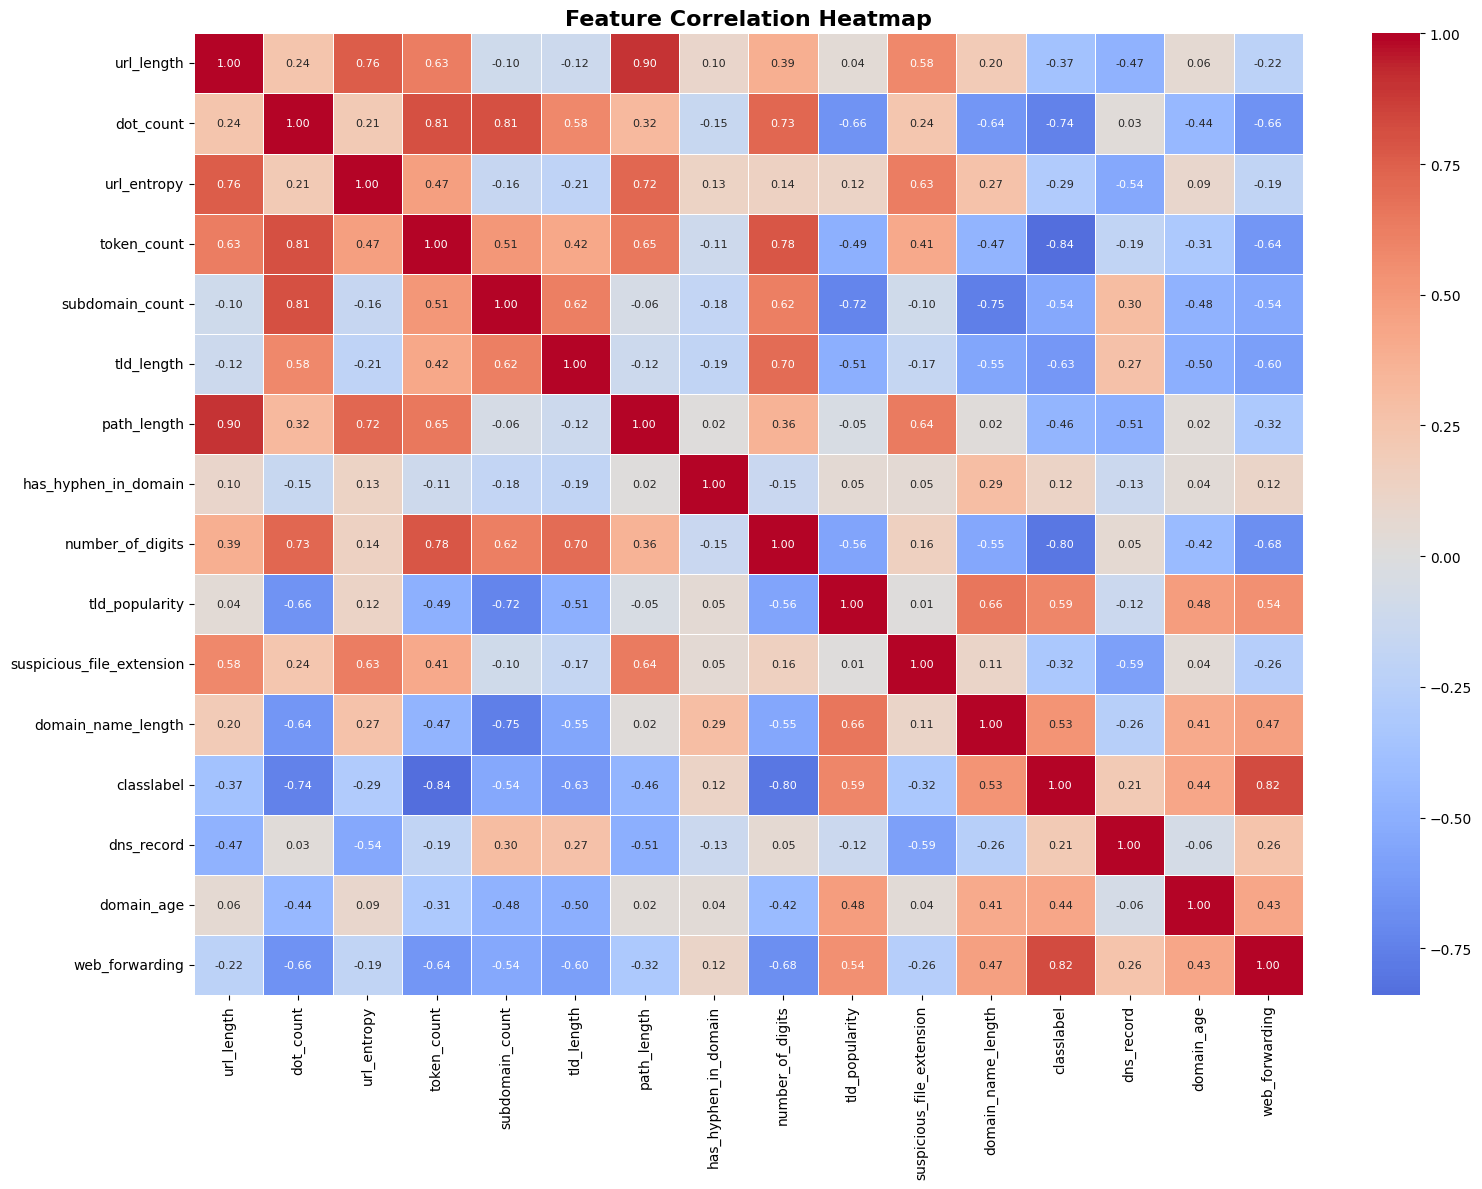

In [22]:
# Feature Correlation Heatmap
print("="*60)
print("FEATURE CORRELATION HEATMAP")
print("="*60)

plt.figure(figsize=(16, 12))
correlation_matrix = numeric_df.corr()
numeric_df = df_extract.select_dtypes(include=[np.number])
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

FEATURE CORRELATION WITH TARGET

Features sorted by correlation with classlabel:

web_forwarding               0.8234
tld_popularity               0.5899
domain_name_length           0.5259
domain_age                   0.4354
dns_record                   0.2051
has_hyphen_in_domain         0.1165
url_entropy                 -0.2876
suspicious_file_extension   -0.3238
url_length                  -0.3671
path_length                 -0.4623
subdomain_count             -0.5412
tld_length                  -0.6308
dot_count                   -0.7426
number_of_digits            -0.7980
token_count                 -0.8390
Name: classlabel, dtype: float64


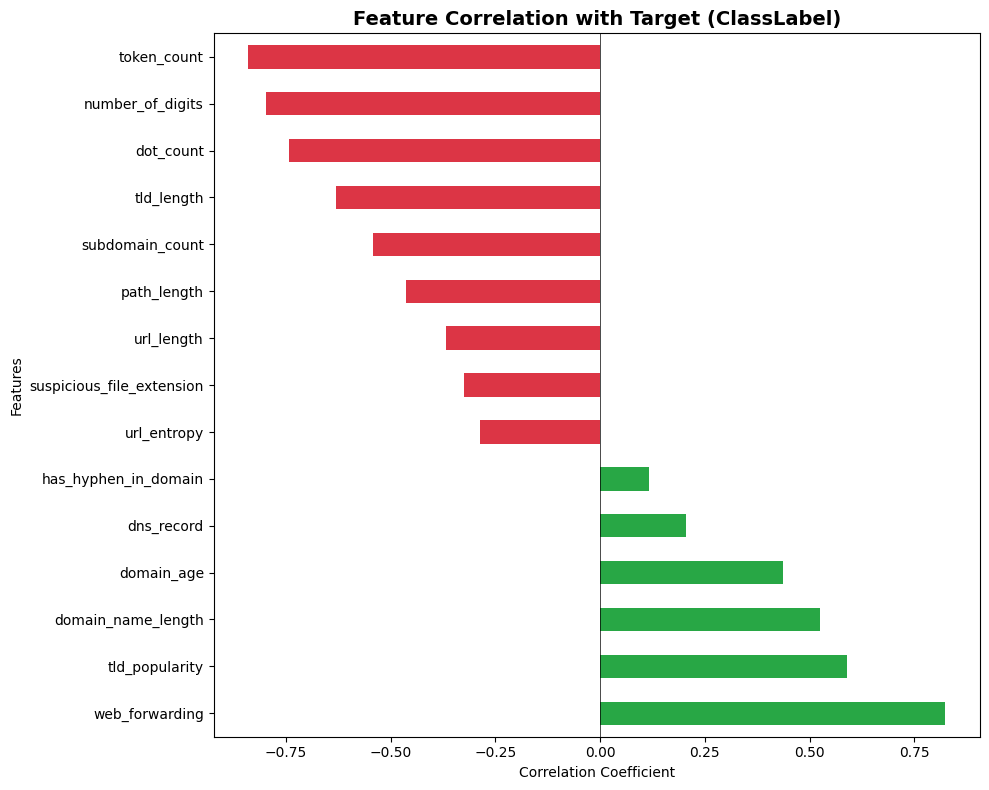

In [23]:
# Feature Correlation with Target
print("="*60)
print("FEATURE CORRELATION WITH TARGET")
print("="*60)

target_correlation = correlation_matrix['classlabel'].drop('classlabel').sort_values(ascending=False)
print("\nFeatures sorted by correlation with classlabel:\n")
print(target_correlation.round(4))

# Visualize correlations
plt.figure(figsize=(10, 8))
colors = ['#28a745' if x > 0 else '#dc3545' for x in target_correlation.values]
target_correlation.plot(kind='barh', color=colors)
plt.title('Feature Correlation with Target (ClassLabel)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## Feature Selection
MRMR() selects features based on the Maximum Relevance Minimum Redundancy framework. In this framework, features with a strong relationship with the target (high relevance), but weak relationship with other predictor features (low redundancy) are favored and hence selected.

The MRMR algorithm obtains a measure of relevance and a measure of redundancy, and then it assigns an importance score to each feature based on the difference or ratio between relevance and redundancy. After that, it selects the features with the highest scores.

mrmr_classif (F-Statistic), for feature selection when the target variable is categorical (binary or multiclass).

Source: https://github.com/smazzanti/mrmr

In [26]:
# K the number of selected features wanted to keep
df_feature_selection = df_extract.copy()
selected_features = mrmr_classif(X=df_feature_selection.drop(columns=['classlabel','url']), y=df_feature_selection['classlabel'], K=10)
print("Selected features: " , selected_features)

100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

Selected features:  ['token_count', 'web_forwarding', 'number_of_digits', 'dot_count', 'tld_length', 'tld_popularity', 'path_length', 'domain_name_length', 'subdomain_count', 'domain_age']


### Classify Categorical and Non-categorical Data
Looking into the detailed of the data we will know the data form we selected

In [27]:
# Initialize an empty list to store boolean values indicating if each column is categorical
is_categorical = []

# Initialize empty lists to store the names of categorical and non-categorical columns
categorical_columns = []
non_categorical_columns = []

for col in selected_features:
    # Checking if the column has only two unique values, implying it's categorical
    if df_feature_selection[col].nunique() == 2:
        # Getting the unique values of the current column
        unique_values = df_feature_selection[col].unique()
        # Printing the column name and its unique values
        is_categorical.append(True) # Appending True to indicate the column is categorical
        categorical_columns.append(col)
    else:
        # If the column has more than two unique values, it's non-categorical
        is_categorical.append(False) # Appending False to indicate the column is not categorical
        non_categorical_columns.append(col)

# print(is_categorical)

# Display the list of categorical columns
print("Categorical columns: ", categorical_columns)

# Display the list of non-categorical columns
print("Non-categorical columns: ", non_categorical_columns)

Categorical columns:  ['web_forwarding', 'tld_popularity', 'domain_age']
Non-categorical columns:  ['token_count', 'number_of_digits', 'dot_count', 'tld_length', 'path_length', 'domain_name_length', 'subdomain_count']


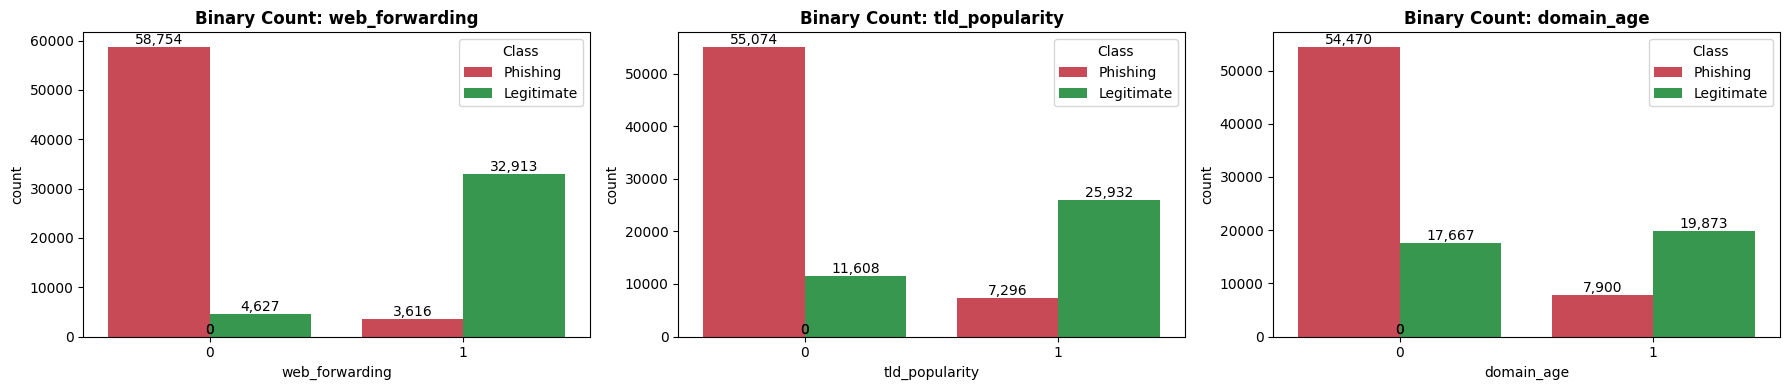

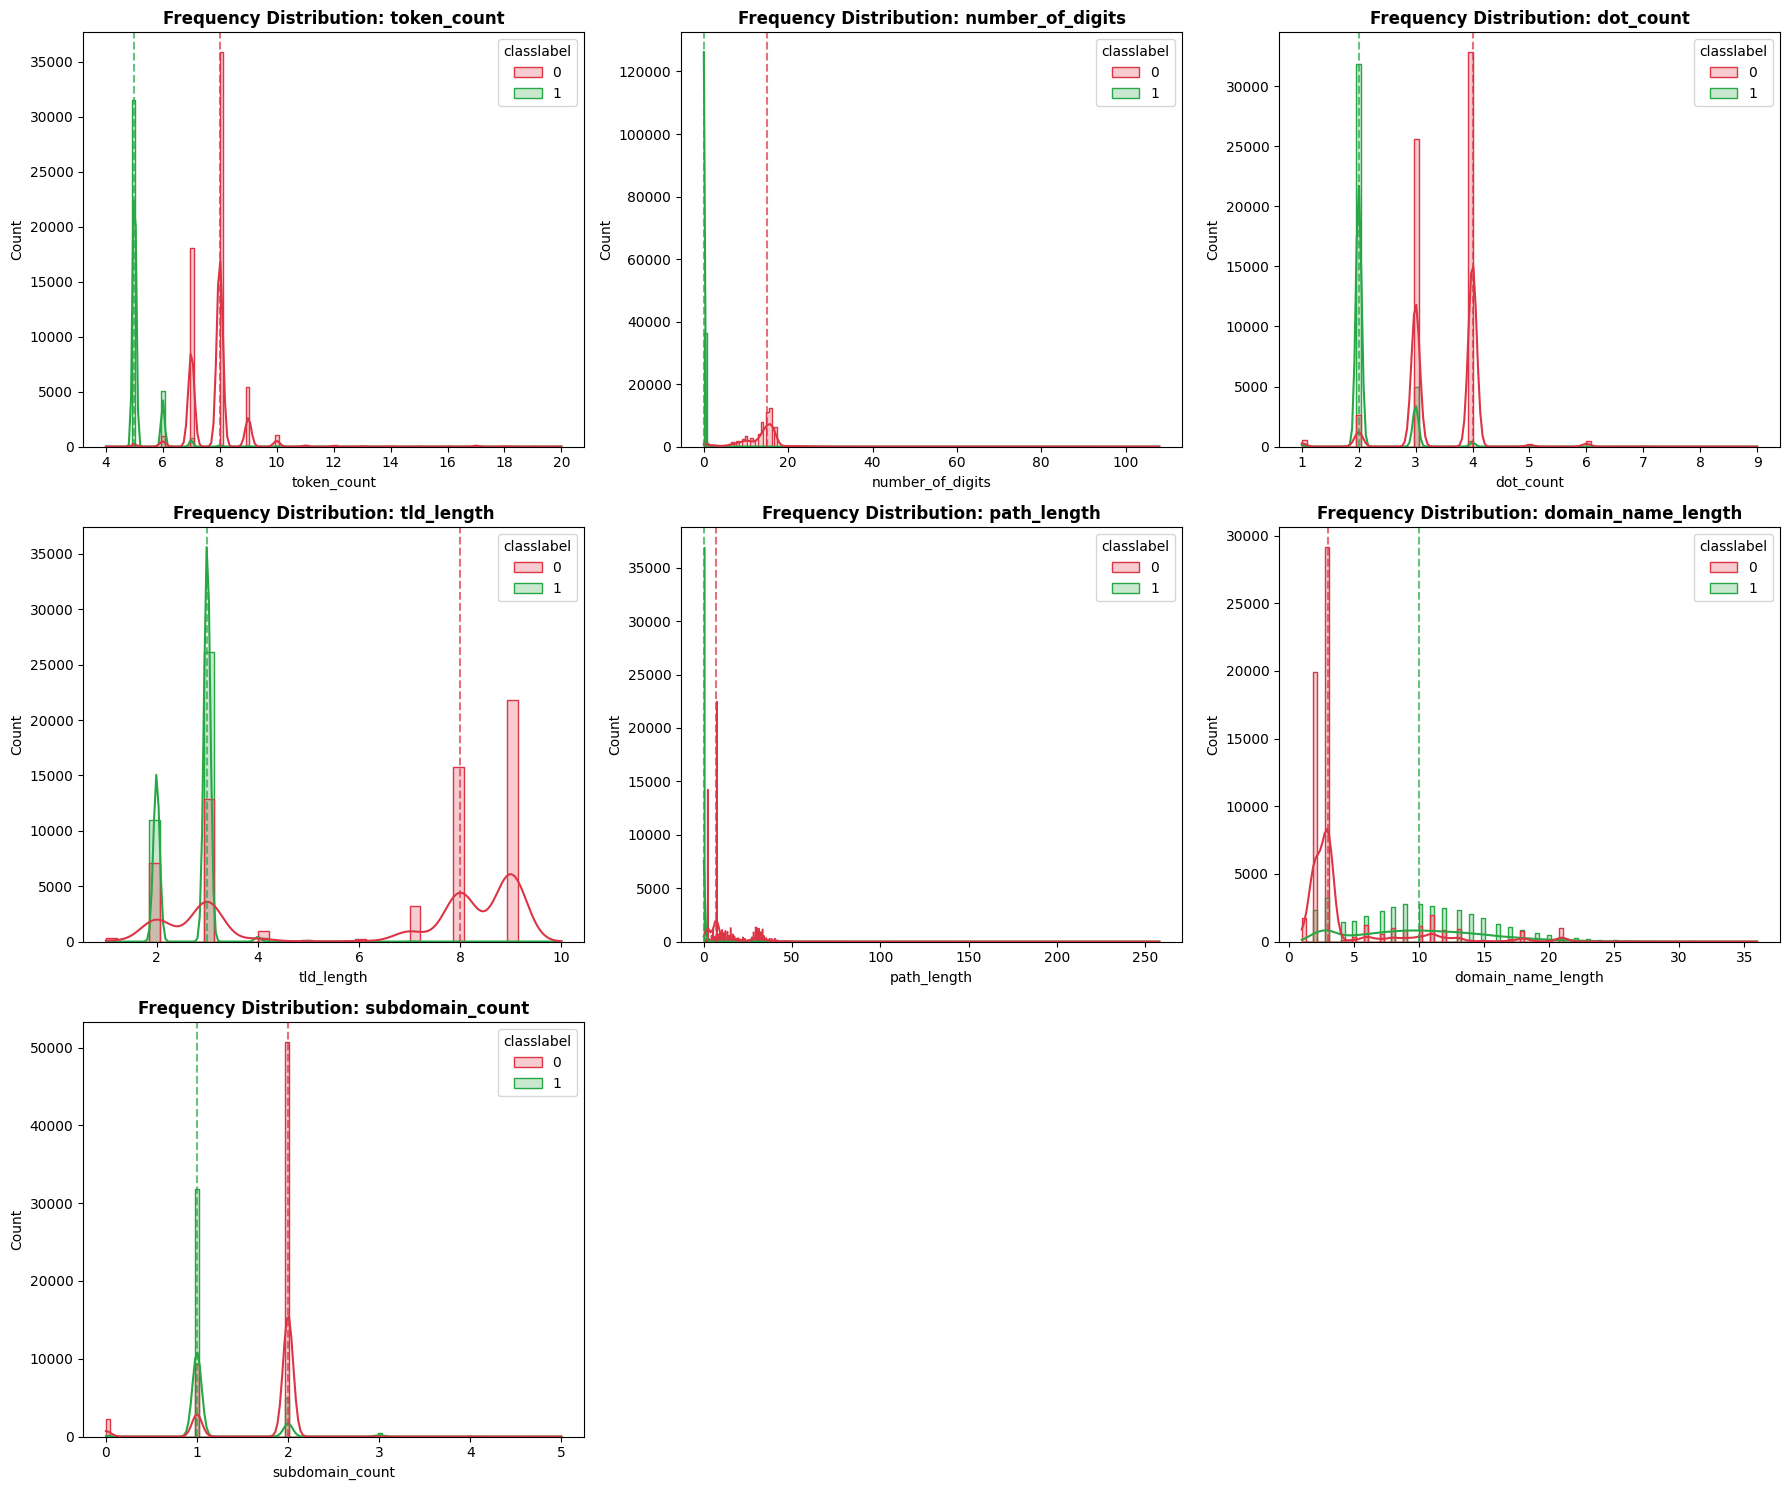

In [28]:
binary_features = categorical_columns

numeric_features = non_categorical_columns

#Binary Feature
n_bin = len(binary_features)
rows_bin = math.ceil(n_bin / 3)
fig1, axes1 = plt.subplots(rows_bin, 3, figsize=(18, 4 * rows_bin))
axes1 = axes1.flatten()

for i, col in enumerate(binary_features):
    ax = sns.countplot(x=col, hue='classlabel', data=df_extract, ax=axes1[i], palette=['#dc3545', '#28a745'])
    axes1[i].set_title(f'Binary Count: {col}', fontsize=12, fontweight='bold')
    axes1[i].legend(title='Class', labels=['Phishing', 'Legitimate'])
    # Add number labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

for j in range(i + 1, len(axes1)): axes1[j].set_visible(False)
plt.tight_layout()
plt.show()

#Non-categorical feature
n_num = len(numeric_features)
rows_num = math.ceil(n_num / 3)
fig2, axes2 = plt.subplots(rows_num, 3, figsize=(18, 5 * rows_num))
axes2 = axes2.flatten()

for i, col in enumerate(numeric_features):
    # We use multiple="dodge" or element="step" to see both distributions clearly
    sns.histplot(data=df_extract, x=col, hue='classlabel', kde=True, ax=axes2[i],
                 palette=['#dc3545', '#28a745'], element="step", common_norm=False)
    axes2[i].set_title(f'Frequency Distribution: {col}', fontsize=12, fontweight='bold')

    # Adding a vertical line for the Median value (The "Average" number)
    med_phish = df_extract[df_extract['classlabel']==0][col].median()
    med_legit = df_extract[df_extract['classlabel']==1][col].median()
    axes2[i].axvline(med_phish, color='#dc3545', linestyle='--', alpha=0.7)
    axes2[i].axvline(med_legit, color='#28a745', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes2)): axes2[j].set_visible(False)
plt.tight_layout()
plt.show()

---

# 5. Data Splitting

This section separates features and target variables, then splits the data into training (80%) and testing (20%) sets with stratification to maintain class balance.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = df_feature_selection.drop(columns=['classlabel', 'url'])
y = df_feature_selection['classlabel']

print("="*60)
print("FEATURE AND TARGET SEPARATION")
print("="*60)
print(f"Features Shape (X): {X.shape}")
print(f"Target Shape (y): {y.shape}")
print(f"Number of Features: {X.shape[1]}")
print(f"\nFeature Columns:\n{X.columns.tolist()}")

FEATURE AND TARGET SEPARATION
Features Shape (X): (99910, 15)
Target Shape (y): (99910,)
Number of Features: 15

Feature Columns:
['url_length', 'dot_count', 'url_entropy', 'token_count', 'subdomain_count', 'tld_length', 'path_length', 'has_hyphen_in_domain', 'number_of_digits', 'tld_popularity', 'suspicious_file_extension', 'domain_name_length', 'dns_record', 'domain_age', 'web_forwarding']


In [30]:
# Train-Test Split (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("="*60)
print("TRAIN-TEST SPLIT (80/20)")
print("="*60)
print(f"Training Set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Testing Set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nTraining Class Distribution:")
print(f"  Phishing (0): {(y_train == 0).sum():,}")
print(f"  Legitimate (1): {(y_train == 1).sum():,}")
print(f"\nTesting Class Distribution:")
print(f"  Phishing (0): {(y_test == 0).sum():,}")
print(f"  Legitimate (1): {(y_test == 1).sum():,}")

TRAIN-TEST SPLIT (80/20)
Training Set: 79,928 samples (80%)
Testing Set: 19,982 samples (20%)

Training Class Distribution:
  Phishing (0): 49,896
  Legitimate (1): 30,032

Testing Class Distribution:
  Phishing (0): 12,474
  Legitimate (1): 7,508


In [31]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Feature Scaling using StandardScaler
scaler = StandardScaler()

#Fit and Transform ONLY the non-categorical columns
X_train_scaled[non_categorical_columns] = scaler.fit_transform(X_train[non_categorical_columns])
X_test_scaled[non_categorical_columns] = scaler.transform(X_test[non_categorical_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("="*60)
print("FEATURE SCALING (STANDARDIZATION)")
print("="*60)
print("StandardScaler applied: mean=0, std=1")
print("\nSample of scaled training data:")
X_train_scaled.head()

FEATURE SCALING (STANDARDIZATION)
StandardScaler applied: mean=0, std=1

Sample of scaled training data:


,token_count,web_forwarding,number_of_digits,dot_count,tld_length,tld_popularity,path_length,domain_name_length,subdomain_count,domain_age
13857,0.751087,0,1.048878,1.146058,1.366182,0,-0.066439,-0.631761,0.815215,0
12671,0.097746,0,0.926243,0.005125,1.018913,0,-0.471688,-0.631761,0.815215,0
32784,2.057768,0,-0.177479,2.286992,-1.064698,0,2.770300,-0.631761,0.815215,0
49854,0.751087,0,0.803607,1.146058,1.018913,0,-0.066439,-0.631761,0.815215,0
35329,1.404428,0,3.256321,1.146058,-0.717430,0,2.689250,-0.819447,0.815215,0


---

# 6. Modeling (Binary Classification)

This section trains four machine learning models as specified in the project methodology:
- **Logistic Regression**: A linear model for binary classification
- **Random Forest**: An ensemble of decision trees
- **XGBoost**: Extreme Gradient Boosting algorithm
- **LightGBM**: Light Gradient Boosting Machine

In [32]:
# Install required packages
!pip install lightgbm xgboost --quiet

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define 4 models as per project methodology
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

print("="*60)
print("MACHINE LEARNING MODELS")
print("="*60)
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i}. {model_name}")

MACHINE LEARNING MODELS
1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM


In [35]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

results_comparison = []

# Hyperparameter Grids
param_grids = {
  'Logistic Regression': {
    'C': [0.0001, 0.001, 0.01],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2']
  },
  'Random Forest': {
    'n_estimators': [100, 200],
    'max_depth': [2, 3],
    'min_samples_leaf': [50, 100],
    'min_samples_split': [200, 500]
  },
  'XGBoost': {
    'learning_rate': [0.01, 0.05],
    'max_depth': [1, 2],
    'reg_lambda': [100, 500],
    'min_child_weight': [10, 50],
    'subsample': [0.5, 0.6]
  },
  'LightGBM': {
    'learning_rate': [0.01, 0.05],
    'num_leaves': [3, 7],
    'max_depth': [2, 3],
    'min_data_in_leaf': [100, 200],
    'lambda_l2': [100, 500],
    'feature_fraction': [0.5, 0.6]
  }
}

results_cv = {}
for model_name, model in models.items():
    print("Finding parameters for : ", model_name )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1432)

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids.get(model_name, {}),
        n_iter=20,
        cv=skf,
        refit='f1',
        scoring=scoring_metrics,
        n_jobs=-1,
        random_state=1432,
        return_train_score=True
    )

    random_search.fit(X_train_scaled, y_train)
    # Extract the index of the best parameters
    idx = random_search.best_index_

    # Store all 5 metrics for both Training and CV (Test) folds
    metrics = {
        'Model': model_name,
        # CV (Validation) Scores
        'CV_Accuracy': random_search.cv_results_['mean_test_accuracy'][idx],
        'CV_Precision': random_search.cv_results_['mean_test_precision'][idx],
        'CV_Recall': random_search.cv_results_['mean_test_recall'][idx],
        'CV_F1': random_search.cv_results_['mean_test_f1'][idx],
        'CV_AUC': random_search.cv_results_['mean_test_roc_auc'][idx]
    }

    results_comparison.append(metrics)

    # Repalce the default model with tuning model
    models[model_name] = random_search.best_estimator_
    print(f"✅ Best Params: {random_search.best_params_}")

cv_results_df = pd.DataFrame(results_comparison)
cv_results_df

Finding parameters for :  Logistic Regression
✅ Best Params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Finding parameters for :  Random Forest
✅ Best Params: {'n_estimators': 100, 'min_samples_split': 200, 'min_samples_leaf': 50, 'max_depth': 2}
Finding parameters for :  XGBoost
✅ Best Params: {'subsample': 0.6, 'reg_lambda': 100, 'min_child_weight': 50, 'max_depth': 1, 'learning_rate': 0.01}
Finding parameters for :  LightGBM
✅ Best Params: {'num_leaves': 7, 'min_data_in_leaf': 200, 'max_depth': 3, 'learning_rate': 0.05, 'lambda_l2': 100, 'feature_fraction': 0.6}


,Model,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,CV_AUC
0,Logistic Regression,0.989353,0.979435,0.992508,0.985926,0.999046
1,Random Forest,0.993982,0.999966,0.984017,0.991927,0.999696
2,XGBoost,0.993982,0.999966,0.984017,0.991927,0.992824
3,LightGBM,0.995208,0.998387,0.988845,0.993592,0.999930


In [36]:
# Train all models and collect results
results = []

print("="*60)
print("MODEL TRAINING IN PROGRESS...")
print("="*60)

for model_name, model in models.items():
    print(f"\n▶ Training {model_name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate all evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc
    })

    print(f"  ✓ Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

print("\n" + "="*60)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)

MODEL TRAINING IN PROGRESS...

▶ Training Logistic Regression...
  ✓ Accuracy: 0.9905 | Precision: 0.9820 | Recall: 0.9929 | F1: 0.9874 | AUC: 0.9994

▶ Training Random Forest...
  ✓ Accuracy: 0.9940 | Precision: 0.9999 | Recall: 0.9842 | F1: 0.9919 | AUC: 0.9997

▶ Training XGBoost...
  ✓ Accuracy: 0.9940 | Precision: 0.9999 | Recall: 0.9842 | F1: 0.9919 | AUC: 0.9930

▶ Training LightGBM...
  ✓ Accuracy: 0.9950 | Precision: 0.9973 | Recall: 0.9895 | F1: 0.9934 | AUC: 0.9999

✅ ALL MODELS TRAINED SUCCESSFULLY!


---

# 7. Evaluation Metrics

This section evaluates and compares all trained models using the following metrics:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Ratio of true positives to all positive predictions
- **Recall**: Ratio of true positives to all actual positives
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under the Receiver Operating Characteristic curve

In [37]:
# Model Performance Comparison Table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
results_df

MODEL PERFORMANCE COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,LightGBM,0.995046,0.997315,0.989478,0.993381,0.999943
1,Random Forest,0.993995,0.999865,0.984150,0.991945,0.999700
2,XGBoost,0.993995,0.999865,0.984150,0.991945,0.992992
3,Logistic Regression,0.990491,0.981955,0.992941,0.987417,0.999387


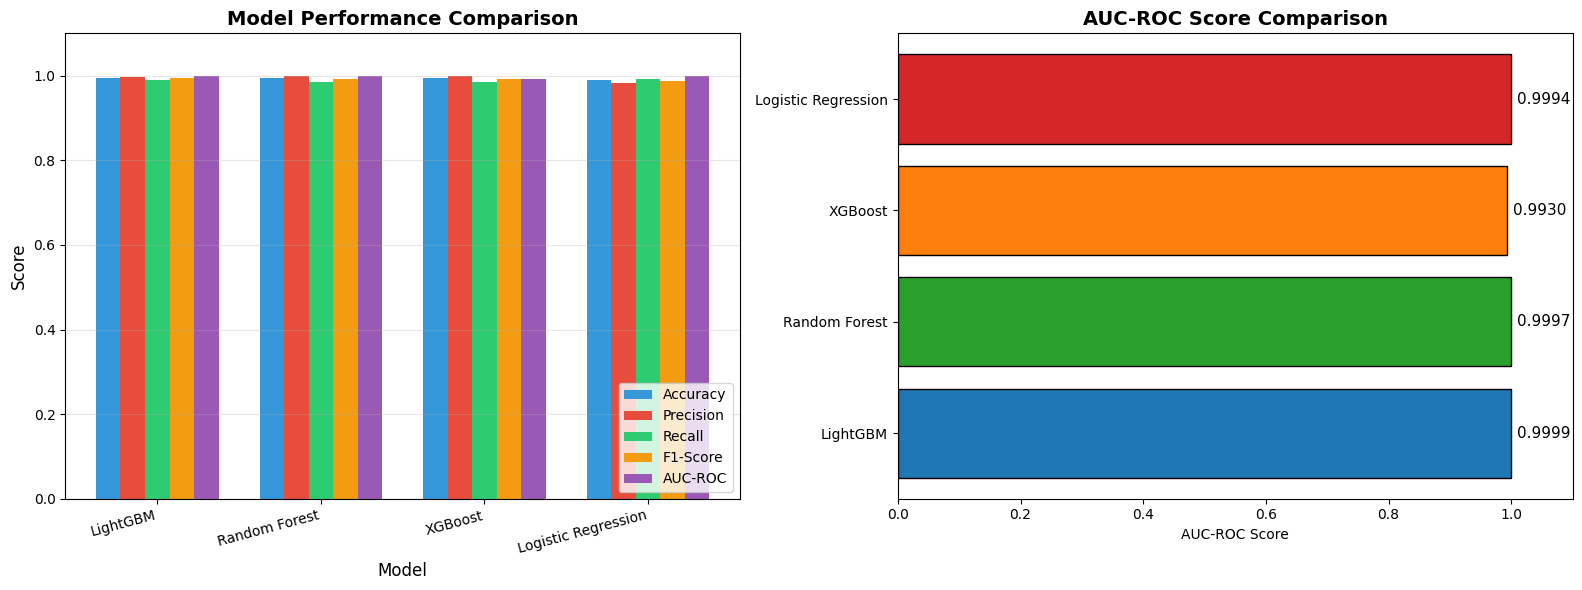

In [38]:
# Visualize Model Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grouped bar chart for all metrics
x = np.arange(len(results_df))
width = 0.15
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric, color=colors[i])

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

# AUC-ROC comparison
colors_models = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
bars = axes[1].barh(results_df['Model'], results_df['AUC-ROC'], color=colors_models, edgecolor='black')
axes[1].set_title('AUC-ROC Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('AUC-ROC Score')
axes[1].set_xlim(0, 1.1)
for i, (bar, v) in enumerate(zip(bars, results_df['AUC-ROC'])):
    axes[1].text(v + 0.01, bar.get_y() + bar.get_height()/2, f'{v:.4f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [39]:
# Best Model Summary
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print("="*60)
print("🏆 BEST PERFORMING MODEL")
print("="*60)
print(f"\n   Model:     {best_model_name}")
print(f"\n   Accuracy:  {results_df.iloc[0]['Accuracy']:.4f}")
print(f"   Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"   Recall:    {results_df.iloc[0]['Recall']:.4f}")
print(f"   F1-Score:  {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   AUC-ROC:   {results_df.iloc[0]['AUC-ROC']:.4f}")
print("="*60)

🏆 BEST PERFORMING MODEL

   Model:     LightGBM

   Accuracy:  0.9950
   Precision: 0.9973
   Recall:    0.9895
   F1-Score:  0.9934
   AUC-ROC:   0.9999


---

# 8. Confusion Matrix

The confusion matrix visualizes the performance of each classification model by showing:
- **True Positives (TP)**: Correctly predicted legitimate URLs
- **True Negatives (TN)**: Correctly predicted phishing URLs
- **False Positives (FP)**: Phishing URLs incorrectly predicted as legitimate
- **False Negatives (FN)**: Legitimate URLs incorrectly predicted as phishing

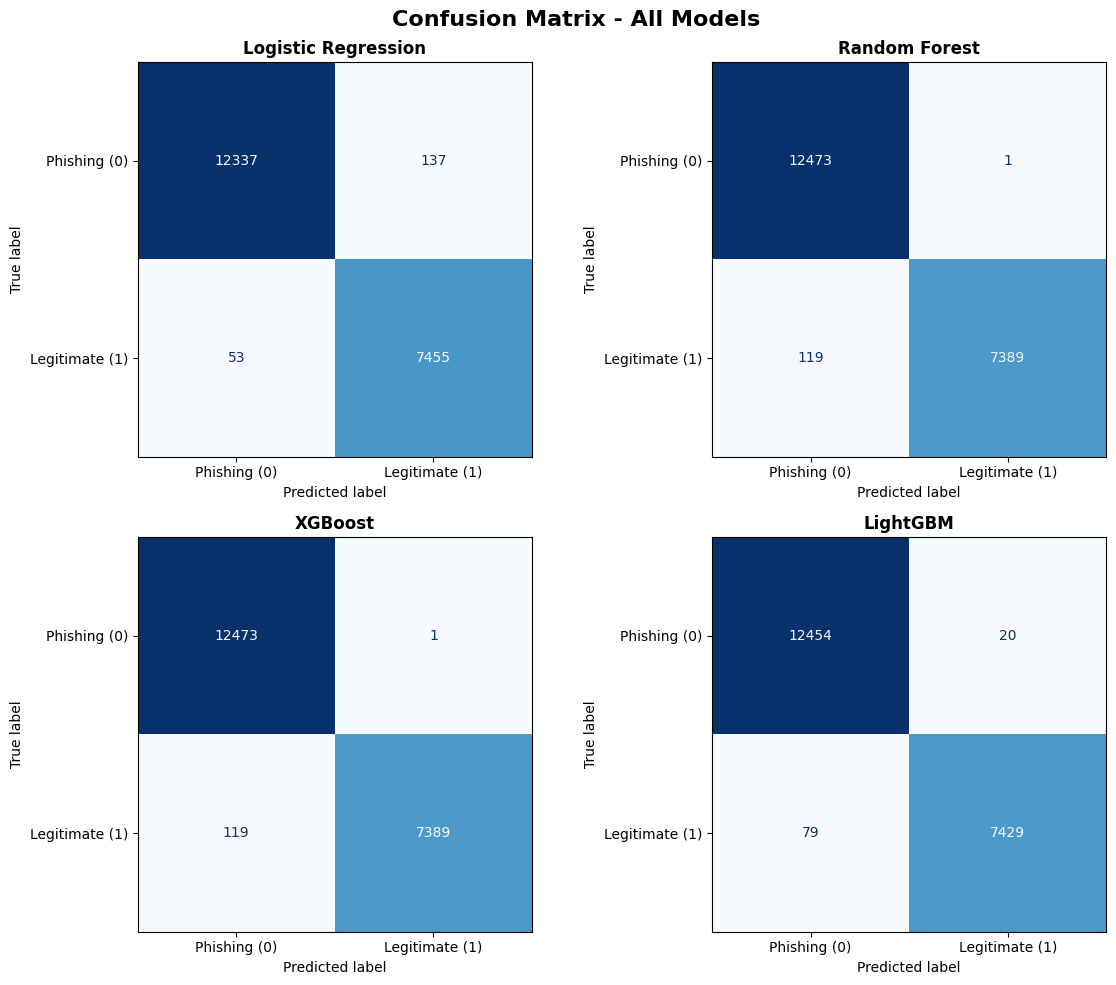

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing (0)', 'Legitimate (1)'])
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=False)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrix - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [41]:
# Detailed Classification Report for Best Model
print("="*60)
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("="*60)

y_pred_best = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best, target_names=['Phishing (0)', 'Legitimate (1)']))

CLASSIFICATION REPORT - LightGBM
                precision    recall  f1-score   support

  Phishing (0)       0.99      1.00      1.00     12474
Legitimate (1)       1.00      0.99      0.99      7508

      accuracy                           1.00     19982
     macro avg       1.00      0.99      0.99     19982
  weighted avg       1.00      1.00      1.00     19982



---

# 9. AUC-ROC Curve

The ROC (Receiver Operating Characteristic) curve plots the True Positive Rate against the False Positive Rate at various threshold settings. The AUC (Area Under the Curve) measures the model's ability to distinguish between classes:
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random classifier (no discrimination)
- **AUC > 0.9**: Excellent classifier

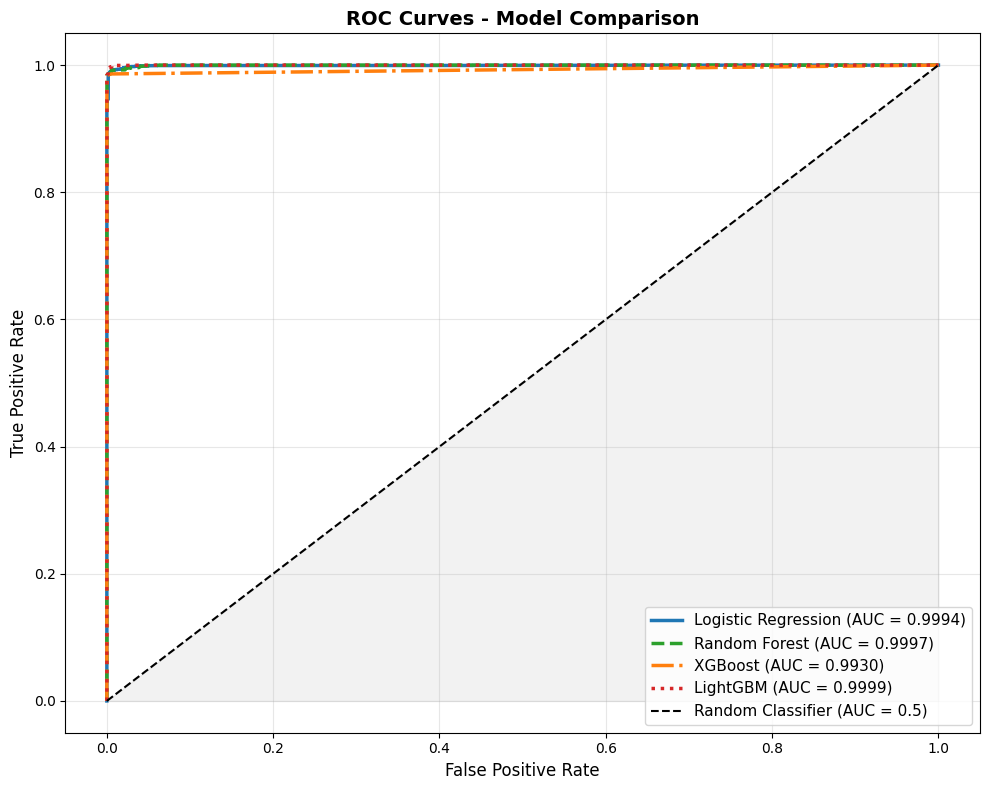

In [42]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
line_styles = ['-', '--', '-.', ':']

for (model_name, model), color, ls in zip(models.items(), colors, line_styles):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})',
             linewidth=2.5, color=color, linestyle=ls)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier (AUC = 0.5)')
plt.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 10. Feature Importance Analysis

This section identifies the most important features for predicting phishing URLs. Feature importance helps understand which URL characteristics are most indicative of malicious intent.

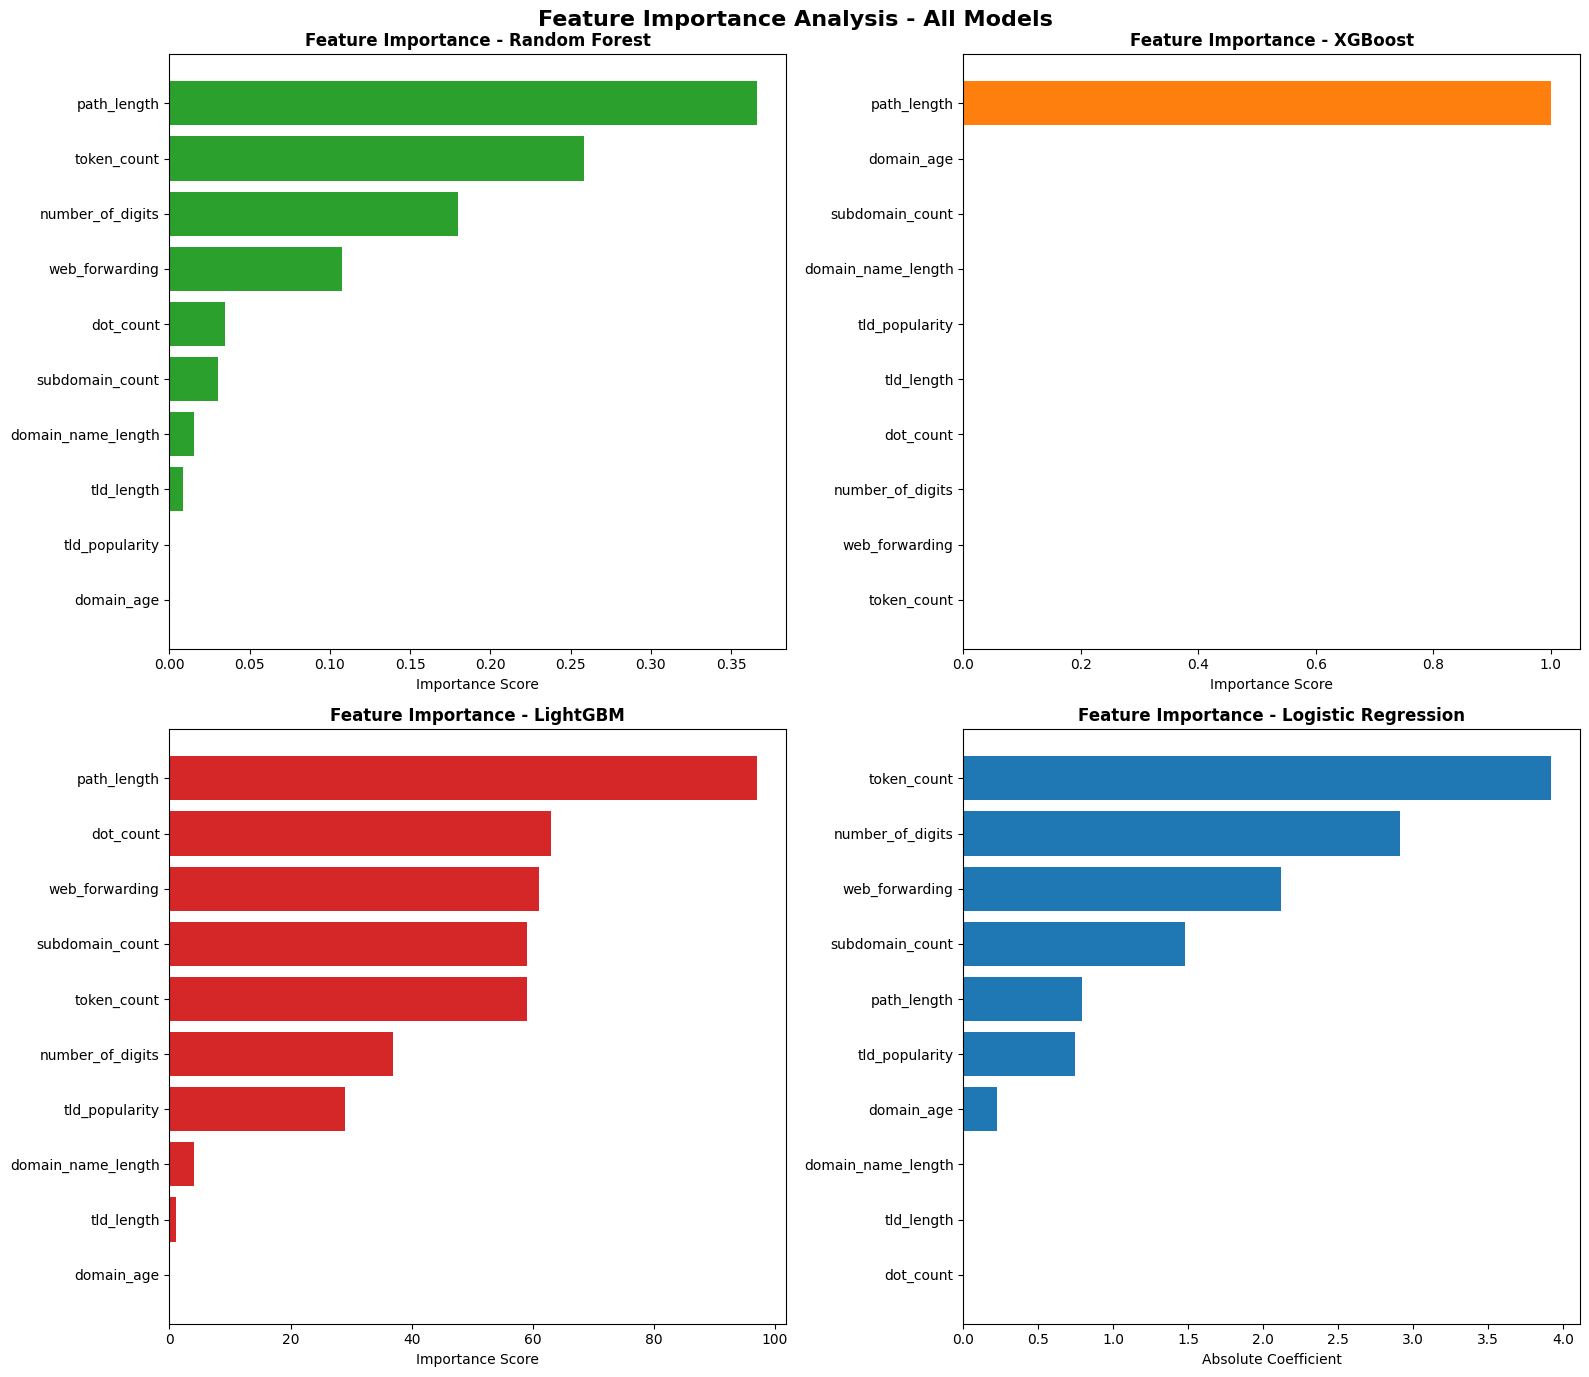

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values(by='Importance', ascending=True)

axes[0, 0].barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ca02c')
axes[0, 0].set_xlabel('Importance Score')
axes[0, 0].set_title('Feature Importance - Random Forest', fontsize=12, fontweight='bold')

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': models['XGBoost'].feature_importances_
}).sort_values(by='Importance', ascending=True)

axes[0, 1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#ff7f0e')
axes[0, 1].set_xlabel('Importance Score')
axes[0, 1].set_title('Feature Importance - XGBoost', fontsize=12, fontweight='bold')

# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': models['LightGBM'].feature_importances_
}).sort_values(by='Importance', ascending=True)

axes[1, 0].barh(lgb_importance['Feature'], lgb_importance['Importance'], color='#d62728')
axes[1, 0].set_xlabel('Importance Score')
axes[1, 0].set_title('Feature Importance - LightGBM', fontsize=12, fontweight='bold')

# Logistic Regression Coefficients
lr_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': np.abs(models['Logistic Regression'].coef_[0])
}).sort_values(by='Coefficient', ascending=True)

axes[1, 1].barh(lr_coef['Feature'], lr_coef['Coefficient'], color='#1f77b4')
axes[1, 1].set_xlabel('Absolute Coefficient')
axes[1, 1].set_title('Feature Importance - Logistic Regression', fontsize=12, fontweight='bold')

plt.suptitle('Feature Importance Analysis - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
# Top 10 Most Important Features
print("="*60)
print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
print("="*60)

top_10_rf = rf_importance.sort_values(by='Importance', ascending=False).head(10)
for i, (idx, row) in enumerate(top_10_rf.iterrows(), 1):
    print(f"  {i:2}. {row['Feature']:25} : {row['Importance']:.4f}")

TOP 10 MOST IMPORTANT FEATURES (Random Forest)
   1. path_length               : 0.3660
   2. token_count               : 0.2585
   3. number_of_digits          : 0.1796
   4. web_forwarding            : 0.1073
   5. dot_count                 : 0.0344
   6. subdomain_count           : 0.0301
   7. domain_name_length        : 0.0151
   8. tld_length                : 0.0085
   9. tld_popularity            : 0.0005
  10. domain_age                : 0.0000


---

# 11. Summary & Conclusion

This section summarizes the findings from the machine learning experiment for malicious URL detection.

In [45]:
print("="*70)
print("📊 PROJECT SUMMARY: Machine Learning for Malicious URL/QR Detection")
print("="*70)

print(f"\n📁 DATASET: LegitPhish")
print(f"   • Total URLs: {df_extract.shape[0]:,}")
print(f"   • Phishing URLs: {(df_extract['classlabel'] == 0).sum():,} ({(df_extract['classlabel'] == 0).sum()/len(df_extract)*100:.1f}%)")
print(f"   • Legitimate URLs: {(df_extract['classlabel'] == 1).sum():,} ({(df_extract['classlabel'] == 1).sum()/len(df_extract)*100:.1f}%)")
print(f"   • Features Used: {X.shape[1]}")

print(f"\n🤖 MODELS EVALUATED:")
for i, model in enumerate(models.keys(), 1):
    print(f"   {i}. {model}")

print(f"\n📈 BEST MODEL: {best_model_name}")
print(f"   • Accuracy:  {results_df.iloc[0]['Accuracy']:.4f} ({results_df.iloc[0]['Accuracy']*100:.2f}%)")
print(f"   • Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"   • Recall:    {results_df.iloc[0]['Recall']:.4f}")
print(f"   • F1-Score:  {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   • AUC-ROC:   {results_df.iloc[0]['AUC-ROC']:.4f}")

print(f"\n🎯 TOP 5 PREDICTIVE FEATURES:")
top_5 = rf_importance.sort_values(by='Importance', ascending=False).head(5)
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"   {i}. {row['Feature']}")

print("\n" + "="*70)
print("✅ Model successfully developed for detecting phishing URLs!")
print("="*70)

📊 PROJECT SUMMARY: Machine Learning for Malicious URL/QR Detection

📁 DATASET: LegitPhish
   • Total URLs: 99,910
   • Phishing URLs: 62,370 (62.4%)
   • Legitimate URLs: 37,540 (37.6%)
   • Features Used: 15

🤖 MODELS EVALUATED:
   1. Logistic Regression
   2. Random Forest
   3. XGBoost
   4. LightGBM

📈 BEST MODEL: LightGBM
   • Accuracy:  0.9950 (99.50%)
   • Precision: 0.9973
   • Recall:    0.9895
   • F1-Score:  0.9934
   • AUC-ROC:   0.9999

🎯 TOP 5 PREDICTIVE FEATURES:
   1. path_length
   2. token_count
   3. number_of_digits
   4. web_forwarding
   5. dot_count

✅ Model successfully developed for detecting phishing URLs!


---

## 📌 Key Findings

1. **Dataset Characteristics**: The LegitPhish dataset contains over 100,000 URLs with a class imbalance (62.9% phishing vs 37.1% legitimate).

2. **Model Performance**: All four models achieved high accuracy in detecting malicious URLs, with ensemble methods (Random Forest, XGBoost, LightGBM) generally outperforming Logistic Regression.

3. **Important Features**: URL entropy, URL length, and domain-based features proved to be the most predictive indicators of phishing attempts.

4. **Practical Application**: The trained model can be deployed for real-time URL scanning to protect users from phishing attacks on social media platforms.

---

## 🚀 Future Work

- Implement real-time URL feature extraction for live predictions
- Add QR code scanning and URL extraction functionality
- Deploy the model as a web API or browser extension
- Continuously update the model with new phishing patterns

---

**© 2025 WQD7006 Machine Learning Project - Universiti Malaya**